AllLife Bank is a US bank that has a growing customer base. The majority of these customers are liability customers (depositors) with varying sizes of deposits. The number of customers who are also borrowers (asset customers) is quite small, and the bank is interested in expanding this base rapidly to bring in more loan business and in the process, earn more through the interest on loans. In particular, the management wants to explore ways of converting its liability customers to personal loan customers (while retaining them as depositors).

A campaign that the bank ran last year for liability customers showed a healthy conversion rate of over 9% success. This has encouraged the retail marketing department to devise campaigns with better target marketing to increase the success ratio.

You as a Data scientist at AllLife bank have to build a model that will help the marketing department to identify the potential customers who have a higher probability of purchasing the loan.

Objective

To predict whether a liability customer will buy a personal loan or not.
Which variables are most significant.
Which segment of customers should be targeted more.


# Data Dictionary


* ID: Customer ID
* Age: Customer’s age in completed years
* Experience: #years of professional experience
* Income: Annual income of the customer (in thousand dollars)
* ZIP Code: Home Address ZIP code.
* Family: the Family size of the customer
* CCAvg: Average spending on credit cards per month (in thousand dollars)
* Education: Education Level. 1: Undergrad; 2: Graduate;3: Advanced/Professional
* Mortgage: Value of house mortgage if any. (in thousand dollars)
* Personal_Loan: Did this customer accept the personal loan offered in the last campaign?
* Securities_Account: Does the customer have securities account with the bank?
* CD_Account: Does the customer have a certificate of deposit (CD) account with the bank?
* Online: Do customers use internet banking facilities?
* CreditCard: Does the customer use a credit card issued by any other Bank (excluding All life Bank)?

# Basic Setup and Imports

In [ ]:
#ignoring warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Libraries to help with reading and manipulating data
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# libaries to help with data visualization
import matplotlib.pyplot as plt       # matplotlib.pyplot plots data
%matplotlib inline 
import seaborn as sns
pd.set_option('mode.chained_assignment', None)

In [ ]:
#restrict float value to 3 decimal places
pd.set_option('display.float_format',lambda x: '%.3f' % x)
%matplotlib inline

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

from sklearn.linear_model import LogisticRegression

# To get diferent metric scores

# Library to split data
from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    plot_confusion_matrix,
    precision_recall_curve,
    roc_curve,
)

In [ ]:
#allow access to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#paths
datapath= "/content/gdrive/MyDrive/AIML-UnivOfTexas/Project3/"

#load csv into panda
ploan_df = pd.read_csv(datapath+ 'Loan_Modelling.csv')

In [ ]:
# copying data to another variable to avoid any changes to original data
ploancp_df = ploan_df.copy()

# Function Definitions 

In [ ]:
#Function to show %
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format

In [ ]:
# function to create labeled barplots

def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [ ]:
#function to show stacked barplots
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 5))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

In [ ]:
### function to plot distributions wrt target

def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
        stat="density",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
        stat="density",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

In [ ]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn

def model_performance_classification_sklearn_with_threshold(model, predictors, target, threshold=0.5):
    """
    Function to compute different metrics, based on the threshold specified, to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """

    # predicting using the independent variables
    pred_prob = model.predict_proba(predictors)[:, 1]
    pred_thres = pred_prob > threshold
    pred = np.round(pred_thres)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
        },
        index=[0],
    )

    return df_perf

In [ ]:
# defining a function to plot the confusion_matrix of a classification model built using sklearn
def confusion_matrix_sklearn_with_threshold(model, predictors, target, threshold=0.5):
    """
    To plot the confusion_matrix, based on the threshold specified, with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """
    pred_prob = model.predict_proba(predictors)[:, 1]
    pred_thres = pred_prob > threshold
    y_pred = np.round(pred_thres)

    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

# Dataset Analysis

### *View Header and Tail*

In [ ]:
ploancp_df.head()

,ID,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
0,1,25,1,49,91107,4,1.600,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.500,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.000,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.700,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.000,2,0,0,0,0,0,1


In [ ]:
ploancp_df.tail()

,ID,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
4995,4996,29,3,40,92697,1,1.900,3,0,0,0,0,1,0
4996,4997,30,4,15,92037,4,0.400,1,85,0,0,0,1,0
4997,4998,63,39,24,93023,2,0.300,3,0,0,0,0,0,0
4998,4999,65,40,49,90034,3,0.500,2,0,0,0,0,1,0
4999,5000,28,4,83,92612,3,0.800,1,0,0,0,0,1,1


### *Visualize the shape and data types of dataset*

In [ ]:
ploancp_df.shape

(5000, 14)

In [ ]:
print("The dataset has", ploancp_df.shape[0], "rows and",ploancp_df.shape[1],"columns.")
number_accounts = ploancp_df.shape[0]

The dataset has 5000 rows and 14 columns.


In [ ]:
ploancp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIPCode             5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal_Loan       5000 non-null   int64  
 10  Securities_Account  5000 non-null   int64  
 11  CD_Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


We can see that all the features are numerical, also that there are no NaN values. However notice that some features are better as Categorical/Object type than Numerical.

### *Summary*

In [ ]:
ploancp_df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,5000.000,2500.500,1443.520,1.000,1250.750,2500.500,3750.250,5000.000
Age,5000.000,45.338,11.463,23.000,35.000,45.000,55.000,67.000
Experience,5000.000,20.105,11.468,-3.000,10.000,20.000,30.000,43.000
Income,5000.000,73.774,46.034,8.000,39.000,64.000,98.000,224.000
ZIPCode,5000.000,93169.257,1759.455,90005.000,91911.000,93437.000,94608.000,96651.000
Family,5000.000,2.396,1.148,1.000,1.000,2.000,3.000,4.000
CCAvg,5000.000,1.938,1.748,0.000,0.700,1.500,2.500,10.000
Education,5000.000,1.881,0.840,1.000,1.000,2.000,3.000,3.000
Mortgage,5000.000,56.499,101.714,0.000,0.000,0.000,101.000,635.000
Personal_Loan,5000.000,0.096,0.295,0.000,0.000,0.000,0.000,1.000


- ID is the same as index, we can drop this feature.
- Age Average age is 45, and the range is from 23 to 67. The age range seems acceptable.
- Experience (Years of Experience) Average is 20, and the range is from -3 to 43. Negatives values are an error. We must address this later.
- Income Average is 73K and the range is from 8K to 224K. This range seems acceptable. 
- Zip Code, This is actually not numerical, but a categorical feature. This may be useful to know which ZIP codes lead to reduced risk customers.
- Family, the Average number of members is 2.4 and the range is from 1 to 4 members. This range is acceptable.
- CCAvg (Monthly Average spending on Credit Card) Average is $1,938, and the range is $0 to $10,000. This range is acceptable.
- Education, This appears as a numerical feature, but it should be categorical. However, according to the feature description, there are only 3 levels of education: 
a) Undergraduate,
b) Graduate,
c) Advanced/Professional

I wonder if the dataset only contains customers that have college degrees, so is "Undergraduate" a customer that has completed college education? "Graduate" means someone that has a masters degree? How about "Advanced/Professional", does this refer to a PhD?

We will analyze this in more detail later.

- Mortage, Personal_Loan, Securities_Account, CD_Account, Online, CreditCard are all boolean fields (or numerical 0 or 1).

# First Data Preparation

Lets do a quick first data preparation process. We can drop the Customer ID.

In [ ]:
#Dropping ID
ploancp_df.drop('ID',axis=1,inplace=True)
ploancp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 5000 non-null   int64  
 1   Experience          5000 non-null   int64  
 2   Income              5000 non-null   int64  
 3   ZIPCode             5000 non-null   int64  
 4   Family              5000 non-null   int64  
 5   CCAvg               5000 non-null   float64
 6   Education           5000 non-null   int64  
 7   Mortgage            5000 non-null   int64  
 8   Personal_Loan       5000 non-null   int64  
 9   Securities_Account  5000 non-null   int64  
 10  CD_Account          5000 non-null   int64  
 11  Online              5000 non-null   int64  
 12  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(12)
memory usage: 507.9 KB


# Univariate Analysis

### *Null Values*

In [ ]:
ploancp_df.isnull().values.any()

False

In [ ]:
ploancp_df.isnull().sum()

Age                   0
Experience            0
Income                0
ZIPCode               0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal_Loan         0
Securities_Account    0
CD_Account            0
Online                0
CreditCard            0
dtype: int64

There are no Null values in the dataset as we had seen earlier.

### *Change Feature Types*

Change features that should be categorical objects:
ZIPCode, Education, Personal_Loan Securities_Account, CD_Account, Online, CreditCard

In [ ]:
cols_num2cat = ['ZIPCode','Education','Personal_Loan','Securities_Account','CD_Account','Online','CreditCard']  
ploancp_df[cols_num2cat] = ploancp_df[cols_num2cat].astype('object')

Review Categorical and Object type features

In [ ]:
numeric_cols = ploancp_df.select_dtypes(include=[np.number]).columns
cat_cols =ploancp_df.describe(include=["object"]).columns

print("Categorical Columns:     ", cat_cols)
print("Numeric Columns:    ", numeric_cols)

Categorical Columns:      Index(['ZIPCode', 'Education', 'Personal_Loan', 'Securities_Account',
       'CD_Account', 'Online', 'CreditCard'],
      dtype='object')
Numeric Columns:     Index(['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Mortgage'], dtype='object')


Checking different levels in categorical data

In [ ]:
# Checking value counts of categorical variables
for i in cat_cols:
    print("*" * 50)
    print("Unique values in", i, "are :")
    print(ploancp_df[i].value_counts())
    print("-" * 50)
    print("Unique values Percentages", i, "are :")
    print(ploancp_df[i].value_counts(1)*100)
   

**************************************************
Unique values in ZIPCode are :
94720    169
94305    127
95616    116
90095     71
93106     57
        ... 
96145      1
94087      1
91024      1
93077      1
94598      1
Name: ZIPCode, Length: 467, dtype: int64
--------------------------------------------------
Unique values Percentages ZIPCode are :
94720   3.380
94305   2.540
95616   2.320
90095   1.420
93106   1.140
         ... 
96145   0.020
94087   0.020
91024   0.020
93077   0.020
94598   0.020
Name: ZIPCode, Length: 467, dtype: float64
**************************************************
Unique values in Education are :
1    2096
3    1501
2    1403
Name: Education, dtype: int64
--------------------------------------------------
Unique values Percentages Education are :
1   41.920
3   30.020
2   28.060
Name: Education, dtype: float64
**************************************************
Unique values in Personal_Loan are :
0    4520
1     480
Name: Personal_Loan, dtype: int64
--

- ZIPCode: Notice that 94720, 94305, 95616,
90095, 93106 represent 10% of all ZIP Codes in the dataset.

- Education: 41.920% have a undergraduate degree, 30.020% a graduate degree, and 28.060% an advanced/professional degree. Are there any customers in the dataset that have no degrees? If the labels are right, all customers have at least a college degree.

- Personal Loan: 90.4% of customers in the dataset do NOT have a personal loan and only 9.6% have a loan.

- Securities Account: 10.44% of customers have a securities account.

- CD Account: 6.040% of customers have a CD account.

- Online Use: 59.680% of customers access their bank account online.

- Credit Card: 29.400% of customers have a credit card with the bank.



### *Single Feature Distributions Plots*

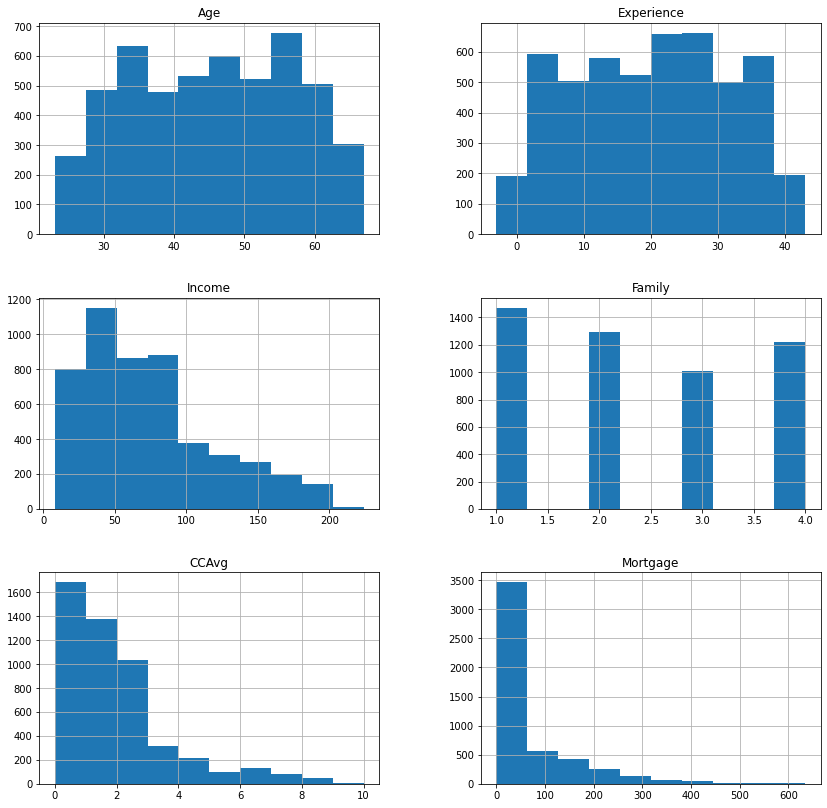

In [ ]:
# creating histograms for numeric_cols
ploancp_df[numeric_cols].hist(figsize=(14, 14))
plt.show()

Notice that roughly Age and Experience are somewhat symmetrical. Income, Mortgage, CCAvg are skewed right. These all make sense.


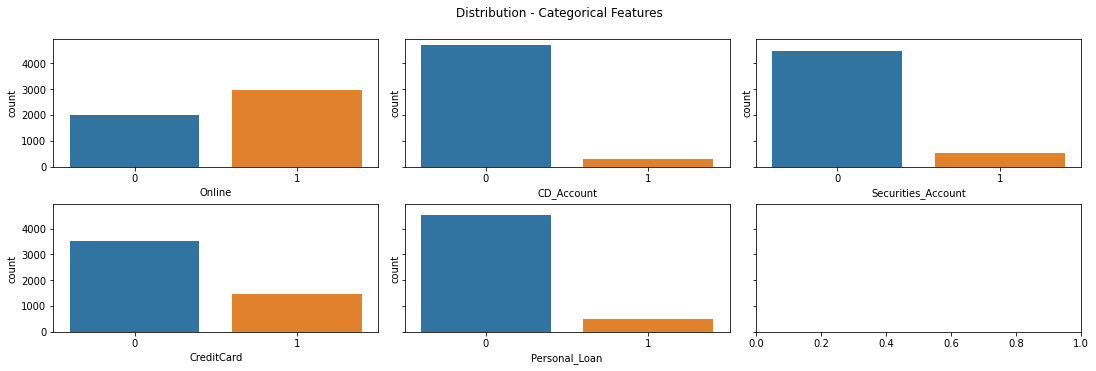

In [ ]:
#create barplots for categorical features

fig, axes = plt.subplots(2, 3, figsize=(15, 5), sharey=True)
fig.tight_layout(h_pad=2)
plt.subplots_adjust(top=0.89)
fig.suptitle('Distribution - Categorical Features')
sns.countplot(ax=axes[1, 1], data=ploancp_df, x='Personal_Loan')
sns.countplot(ax=axes[0, 2], data=ploancp_df, x='Securities_Account')
sns.countplot(ax=axes[0, 1], data=ploancp_df, x='CD_Account')
sns.countplot(ax=axes[0, 0], data=ploancp_df, x='Online')
sns.countplot(ax=axes[1, 0], data=ploancp_df, x='CreditCard')

plt.show()

We noticed that most customers access their account Online, a small percentage of customers have CD Account, a Securities Account or a Personal Loan, and some have a Credit card.

Visualizing these as pie charts may be more useful.

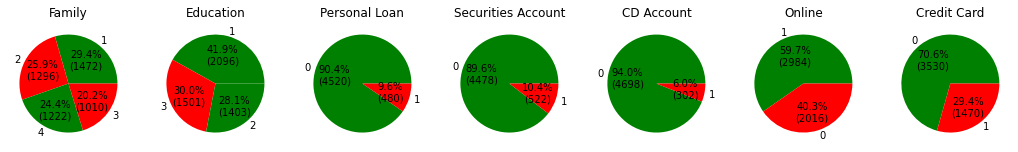

In [ ]:
#visualization Single Features as pie plots with percentage of total

fig, axes = plt.subplots(1, 7, figsize=(18, 18), sharey=True)

data_fy=ploancp_df['Family'].value_counts()
data_ed=ploancp_df['Education'].value_counts()
data_pl=ploancp_df['Personal_Loan'].value_counts()
data_sa =ploancp_df['Securities_Account'].value_counts()
data_cd = ploancp_df['CD_Account'].value_counts()
data_online =ploancp_df['Online'].value_counts()
data_cc = ploancp_df['CreditCard'].value_counts()

plt.title("Distribution - Single Feature")

ax1 = plt.subplot2grid((1,7), (0,0))
plt.pie(data_fy,labels=data_fy.index, autopct=autopct_format(data_fy),colors=("g","r"))
plt.title('Family')

ax1 = plt.subplot2grid((1,7), (0,1))
plt.pie(data_ed,labels=data_ed.index, autopct=autopct_format(data_ed),colors=("g","r"))
plt.title('Education')

ax1 = plt.subplot2grid((1,7),(0,2))
plt.pie(data_pl,labels=data_pl.index, autopct=autopct_format(data_pl),colors=("g","r"))
plt.title('Personal Loan')

ax1 = plt.subplot2grid((1,7), (0, 3))
plt.pie(data_sa,labels=data_sa.index, autopct=autopct_format(data_sa),colors=("g","r"))
plt.title('Securities Account')

ax1 = plt.subplot2grid((1,7), (0, 4))
plt.pie(data_cd,labels=data_cd.index, autopct=autopct_format(data_cd),colors=("g","r"))
plt.title('CD Account')

ax1 = plt.subplot2grid((1,7), (0, 5))
plt.pie(data_online,labels=data_online.index, autopct=autopct_format(data_online),colors=("g","r"))
plt.title('Online')

ax1 = plt.subplot2grid((1,7), (0, 6))
plt.pie(data_cc,labels=data_cc.index, autopct=autopct_format(data_cc),colors=("g","r"))
plt.title('Credit Card')

plt.show()

The same features visualized as pie charts with amounts and percentages of the total. Notice that 30% of customers have a credit card with the bank, 40% access their accounts online, 10% have a securities account, 9.6% have a Personal Loan, and 6% have a CD account.

### *Analysis Feature: Age*

Lets take a look at Age in more detail.

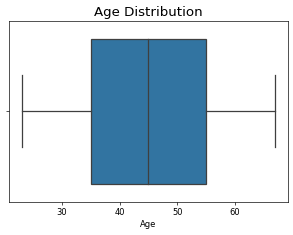

In [ ]:
plt.figure(figsize=(6,4), dpi= 60)

plt.title("Age Distribution", fontsize=16)
sns.boxplot(data=ploancp_df,x='Age')
plt.show()

The age distribution doesn't have any outliers and the median is nicely distributed between Q1 and Q3. 

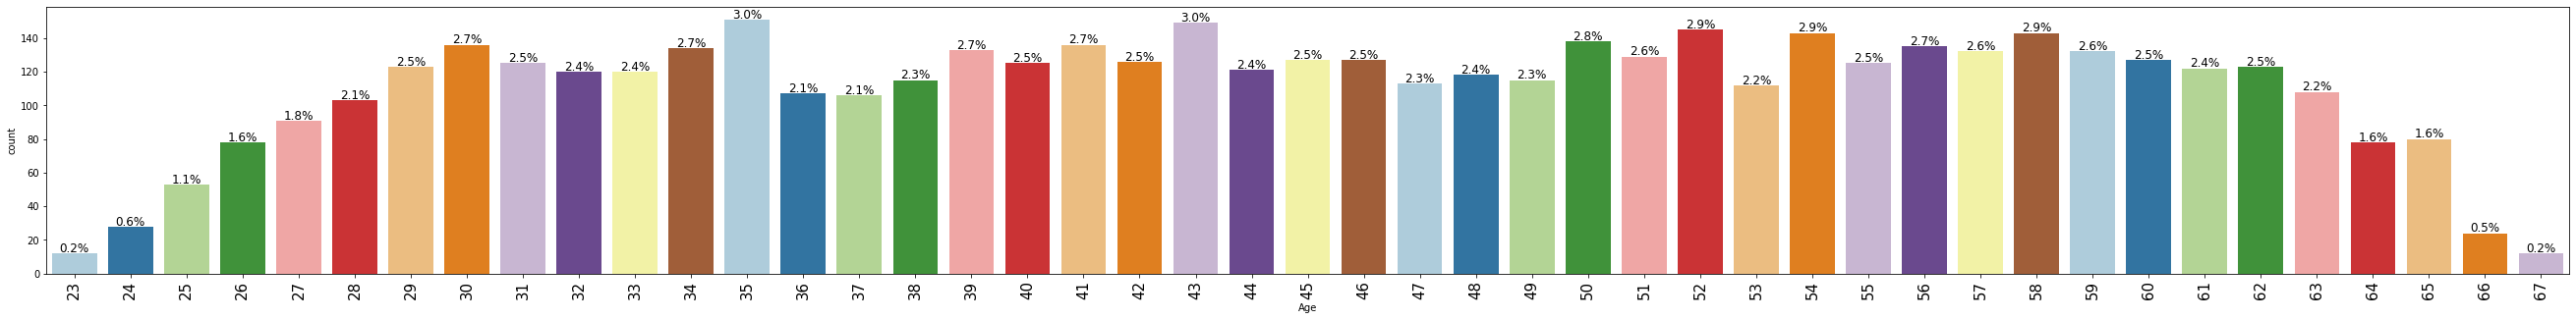

In [ ]:
#same but as barplots
labeled_barplot(ploancp_df, 'Age', perc=True, n=None)

### *Analysis Feature: Experience*

We has observed earlier that the min Experience was a negative number. Lets take a look into that.

In [ ]:
#How many Experience values are negative
num_exp_negative= ploancp_df.loc[ploancp_df['Experience']<0].value_counts().sum()
num_total_cust = ploan_df.shape[0]
print("The number of customers w/ apparent Negative experience is",num_exp_negative,"which represents",(num_exp_negative/num_total_cust)*100,"% of the total customers.")

The number of customers w/ apparent Negative experience is 52 which represents 1.04 % of the total customers.


In [ ]:
#see the negative experience accounts
ploancp_df.loc[ploancp_df['Experience']<0]

,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
89,25,-1,113,94303,4,2.300,3,0,0,0,0,0,1
226,24,-1,39,94085,2,1.700,2,0,0,0,0,0,0
315,24,-2,51,90630,3,0.300,3,0,0,0,0,1,0
451,28,-2,48,94132,2,1.750,3,89,0,0,0,1,0
524,24,-1,75,93014,4,0.200,1,0,0,0,0,1,0
536,25,-1,43,92173,3,2.400,2,176,0,0,0,1,0
540,25,-1,109,94010,4,2.300,3,314,0,0,0,1,0
576,25,-1,48,92870,3,0.300,3,0,0,0,0,0,1
583,24,-1,38,95045,2,1.700,2,0,0,0,0,1,0
597,24,-2,125,92835,2,7.200,1,0,0,1,0,0,1


In [ ]:
#common Experience values and counts
ploancp_df['Experience'].value_counts()

 32    154
 20    148
 9     147
 5     146
 23    144
 35    143
 25    142
 28    138
 18    137
 19    135
 26    134
 24    131
 3     129
 16    127
 14    127
 30    126
 17    125
 34    125
 27    125
 22    124
 29    124
 7     121
 6     119
 15    119
 8     119
 10    118
 13    117
 33    117
 11    116
 37    116
 36    114
 21    113
 4     113
 31    104
 12    102
 38     88
 2      85
 39     85
 1      74
 0      66
 40     57
 41     43
-1      33
-2      15
 42      8
-3       4
 43      3
Name: Experience, dtype: int64

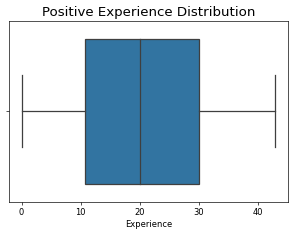

In [ ]:
plt.figure(figsize=(6,4), dpi= 60)
plt.title("Positive Experience Distribution", fontsize=16)
sns.boxplot(data=ploancp_df.loc[ploancp_df['Experience']>=0],x='Experience')
plt.show()

Positive Experience is nicely distributed with a median (Q2) around 20 years, Q1 around 11, and Q3 around 30.

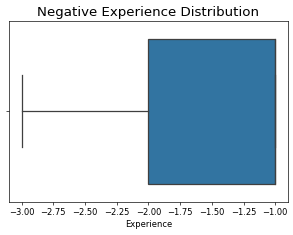

In [ ]:
plt.figure(figsize=(6,4), dpi= 60)

plt.title("Negative Experience Distribution", fontsize=16)
sns.boxplot(data=ploancp_df.loc[ploancp_df['Experience']<0],x='Experience')
plt.show()

In [ ]:
#experience = -3
ploancp_x3_df = ploancp_df.loc[ploancp_df['Experience']==-3]
ploancp_x3_df

,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
2618,23,-3,55,92704,3,2.400,2,145,0,0,0,1,0
3626,24,-3,28,90089,4,1.000,3,0,0,0,0,0,0
4285,23,-3,149,93555,2,7.200,1,0,0,0,0,1,0
4514,24,-3,41,91768,4,1.000,3,0,0,0,0,1,0


Notice that there are only 4 entries with a negative experience -3. 
Lets contrast them to Age and Education because these 2 other features are also related with time.


In [ ]:
#experience = -2
ploancp_x2_df = ploancp_df.loc[ploancp_df['Experience']==-2]
ploancp_x2_df

,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
315,24,-2,51,90630,3,0.300,3,0,0,0,0,1,0
451,28,-2,48,94132,2,1.750,3,89,0,0,0,1,0
597,24,-2,125,92835,2,7.200,1,0,0,1,0,0,1
793,24,-2,150,94720,2,2.000,1,0,0,0,0,1,0
889,24,-2,82,91103,2,1.600,3,0,0,0,0,1,1
2466,24,-2,80,94105,2,1.600,3,0,0,0,0,1,0
2717,23,-2,45,95422,4,0.600,2,0,0,0,0,1,1
2876,24,-2,80,91107,2,1.600,3,238,0,0,0,0,0
2962,23,-2,81,91711,2,1.800,2,0,0,0,0,0,0
3130,23,-2,82,92152,2,1.800,2,0,0,1,0,0,1


Notice that the Age range for experience=-2 is between 23 to 28.

In [ ]:
#experience = -1
ploancp_x1_df = ploancp_df.loc[ploancp_df['Experience']==-1]
ploancp_x1_df

,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
89,25,-1,113,94303,4,2.300,3,0,0,0,0,0,1
226,24,-1,39,94085,2,1.700,2,0,0,0,0,0,0
524,24,-1,75,93014,4,0.200,1,0,0,0,0,1,0
536,25,-1,43,92173,3,2.400,2,176,0,0,0,1,0
540,25,-1,109,94010,4,2.300,3,314,0,0,0,1,0
576,25,-1,48,92870,3,0.300,3,0,0,0,0,0,1
583,24,-1,38,95045,2,1.700,2,0,0,0,0,1,0
649,25,-1,82,92677,4,2.100,3,0,0,0,0,1,0
670,23,-1,61,92374,4,2.600,1,239,0,0,0,1,0
686,24,-1,38,92612,4,0.600,2,0,0,0,0,1,0


Now for Experience=-1, the age range is between 23 and 29.

How about 0 Experience? Is that value registered?

In [ ]:
#experience = 0
ploancp_x0_df = ploancp_df.loc[ploancp_df['Experience']==0]
x0_median=ploancp_x0_df['Age'].median()
x0_min=ploancp_x0_df['Age'].min()
x0_max=ploancp_x0_df['Age'].max()

ploancp_x0_df

,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
105,24,0,35,94704,3,0.100,2,0,0,1,0,1,0
151,26,0,132,92834,3,6.500,3,0,1,0,0,0,1
155,24,0,60,94596,4,1.600,1,0,0,0,0,1,0
156,26,0,15,92131,4,0.400,1,0,0,0,0,0,1
160,29,0,134,95819,4,6.500,3,0,1,0,0,0,0
182,24,0,135,95133,1,1.500,1,0,0,0,0,1,0
256,26,0,99,92697,4,2.300,3,0,0,0,0,0,1
347,25,0,43,94305,2,1.600,3,0,0,1,1,1,1
363,25,0,30,92691,2,1.700,2,0,0,0,0,0,0
379,25,0,28,92093,2,1.700,2,0,0,0,0,0,0


In [ ]:
print("For Experience 0, The minimum age is",x0_min, ",the mean age is",x0_median,",the max age is",x0_max)

For Experience 0, The minimum age is 24 ,the mean age is 26.0 ,the max age is 30


We can see that there are many customers with Experience 0. 

In [ ]:
#also for our plotting lets have a dataframe that includes all negative Experience.
ploancp_negEx_df = ploancp_df.loc[ploancp_df['Experience']<0]

We have to take care of the negative values.

Look at Experience -3, -2, -1. As we know, negative experience is not a valid value. How can we treat these negative values?

- Change them to the mode or median?
- Replace them with a 0?
- Change them to positive?
- Drop those rows?

We will do this during our bivariate analysis because we need to analyze Experience with other Time dependant features like Age and Education.

### *Analysis Feature: Income*

Lets take a look at income in more detail.

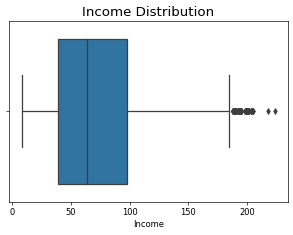

In [ ]:
plt.figure(figsize=(6,4), dpi= 60)
plt.title("Income Distribution", fontsize=16)
sns.boxplot(x='Income', data=ploancp_df, notch=False)
plt.show()

The median is 73,774 (obtaine from Description) and shown in the boxplot above. Notice that some customers make over 180K but these outliers are valid data. 

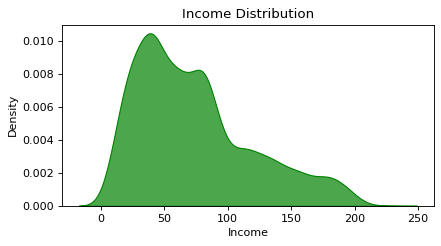

In [ ]:
plt.figure(figsize=(6,3), dpi= 80)
sns.kdeplot(ploancp_df['Income'], shade=True, color="g", alpha=.7)
plt.title("Income Distribution")
plt.show()

Lets bin the income to make a bar plot. From Description we know what the min, max, median values are. But lets get them again.

In [ ]:
income_min = ploancp_df['Income'].min()
income_max = ploancp_df['Income'].max()
income_mean = ploancp_df['Income'].median()
print("The Income minimum is", income_min, "K, the Income mean is", income_mean,"K, and the Income max is",income_max,"K")

The Income minimum is 8 K, the Income mean is 64.0 K, and the Income max is 224 K


In [ ]:
bins = [0, 25, 50, 75, 100, 125, 150, 175, 200, 225]
labels = ['[0..25)','[25..50)','[50..75)', '[75..100)','[100..125)','[125..150)','[150..175)','[175..200)','[200..225]']
ploancp_df['Income_bin'] = pd.cut(ploancp_df['Income'], bins=bins, labels=labels)
print (ploancp_df)

      Age  Experience  Income ZIPCode  Family  CCAvg Education  Mortgage  \
0      25           1      49   91107       4  1.600         1         0   
1      45          19      34   90089       3  1.500         1         0   
2      39          15      11   94720       1  1.000         1         0   
3      35           9     100   94112       1  2.700         2         0   
4      35           8      45   91330       4  1.000         2         0   
...   ...         ...     ...     ...     ...    ...       ...       ...   
4995   29           3      40   92697       1  1.900         3         0   
4996   30           4      15   92037       4  0.400         1        85   
4997   63          39      24   93023       2  0.300         3         0   
4998   65          40      49   90034       3  0.500         2         0   
4999   28           4      83   92612       3  0.800         1         0   

     Personal_Loan Securities_Account CD_Account Online CreditCard Income_bin  
0      

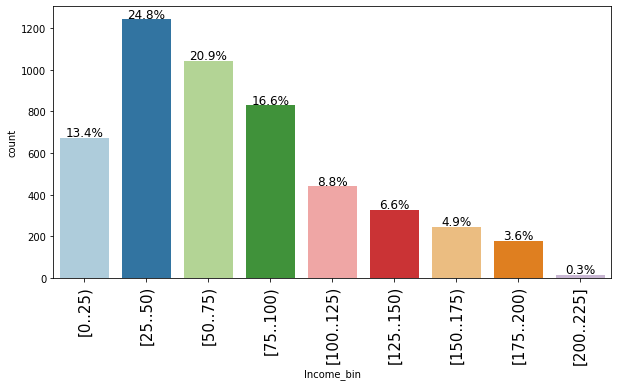

In [ ]:
labeled_barplot(ploancp_df, 'Income_bin', perc=True, n=None)

Notice that 25% of customers are in the [25..50) bin, and 20% are in the [50..75) bin.

### *Analysis Feature: ZIPCode*

Lets analyze ZIP Codes in more detail.

In [ ]:
#Show unique ZIPCodes.
ploancp_df['ZIPCode'].unique()

array([91107, 90089, 94720, 94112, 91330, 92121, 91711, 93943, 93023,
       94710, 90277, 93106, 94920, 91741, 95054, 95010, 94305, 91604,
       94015, 90095, 91320, 95521, 95064, 90064, 94539, 94104, 94117,
       94801, 94035, 92647, 95814, 94114, 94115, 92672, 94122, 90019,
       95616, 94065, 95014, 91380, 95747, 92373, 92093, 94005, 90245,
       95819, 94022, 90404, 93407, 94523, 90024, 91360, 95670, 95123,
       90045, 91335, 93907, 92007, 94606, 94611, 94901, 92220, 93305,
       95134, 94612, 92507, 91730, 94501, 94303, 94105, 94550, 92612,
       95617, 92374, 94080, 94608, 93555, 93311, 94704, 92717, 92037,
       95136, 94542, 94143, 91775, 92703, 92354, 92024, 92831, 92833,
       94304, 90057, 92130, 91301, 92096, 92646, 92182, 92131, 93720,
       90840, 95035, 93010, 94928, 95831, 91770, 90007, 94102, 91423,
       93955, 94107, 92834, 93117, 94551, 94596, 94025, 94545, 95053,
       90036, 91125, 95120, 94706, 95827, 90503, 90250, 95817, 95503,
       93111, 94132,

In [ ]:
numUniqueZips=ploancp_df['ZIPCode'].nunique()
print("The number of ZIPCodes is",numUniqueZips)

The number of ZIPCodes is 467


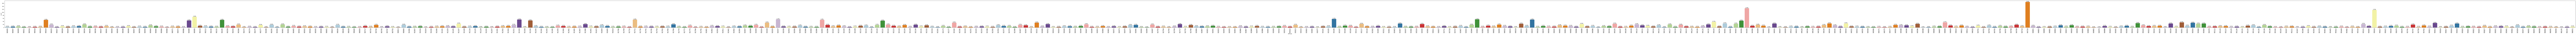

In [ ]:
labeled_barplot(ploancp_df, 'ZIPCode', perc=True, n=None)

This is also very difficult to visualize and alone it doesn't really give us much information. We will revise it during our bivariate analysis.

### *Analysis Feature: Family*

We visualized Family earlier as a pie chart w/ percentage.

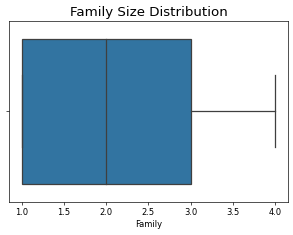

In [ ]:
plt.figure(figsize=(6,4), dpi= 60)

plt.title("Family Size Distribution", fontsize=16)
sns.boxplot(data=ploancp_df,x='Family')
plt.show()

We see that the median is at 2 members per family, 1 is Q1, 3 is Q3. 

### *Analysis Feature: Education*

The description states that 1: undergraduate, 2: graduate, 3: advanced/professional degree.

In [ ]:
education_count = ploancp_df['Education'].value_counts()
education_count

1    2096
3    1501
2    1403
Name: Education, dtype: int64

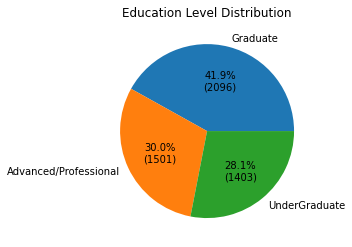

In [ ]:
#lets revisit the pie chart for Education, now with the proper labels
ed_df = ploancp_df['Education'].value_counts()
edlabels = {'UnderGraduate','Graduate','Advanced/Professional'}
plt.pie(ed_df,labels = edlabels, autopct=autopct_format(ed_df))
plt.title("Education Level Distribution")

plt.show()

Is the Education definition correct. Are all customers in the dataset college educated? Was the dataset made to only include college educated customers?

But in any case, lets stick to the categorization made by the bank which states that all customers in this dataset are college educated. 

### *Analysis Feature: Credit Card Use*

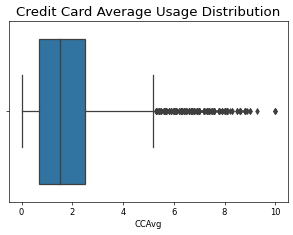

In [ ]:
plt.figure(figsize=(6,4), dpi= 60)
plt.title("Credit Card Average Usage Distribution", fontsize=16)
sns.boxplot(data=ploancp_df,x='CCAvg')
plt.show()

There are many outliers. However, these may be possible. During our bivariate analysis, we will take a look at Credit Card average usage again to obtain more meaningful information.

### *Analysis Feature: Mortgage*

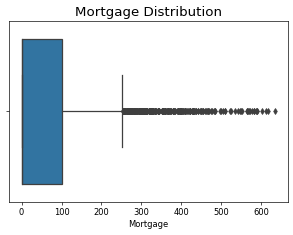

In [ ]:
#Mortage Distribution
plt.figure(figsize=(6,4), dpi= 60)
plt.title("Mortgage Distribution", fontsize=16)
sns.boxplot(data=ploancp_df,x='Mortgage')
plt.show()

Wouldn't Credit Card usage as a Percentage of Income be more useful?  We will take a look at it later during the bivariate analysis.

### *Analysis Feature: Online, CD Account, Credit Card, Security Account*

We have visualized these as countplots and as pie charts.  What other insights can we obtain from these from a univariate analysis? Probably not much than we already saw earlier. So let's move on with the bivariate analysis.

# Bivariate Analysis

### *Age vs Personal Loan*

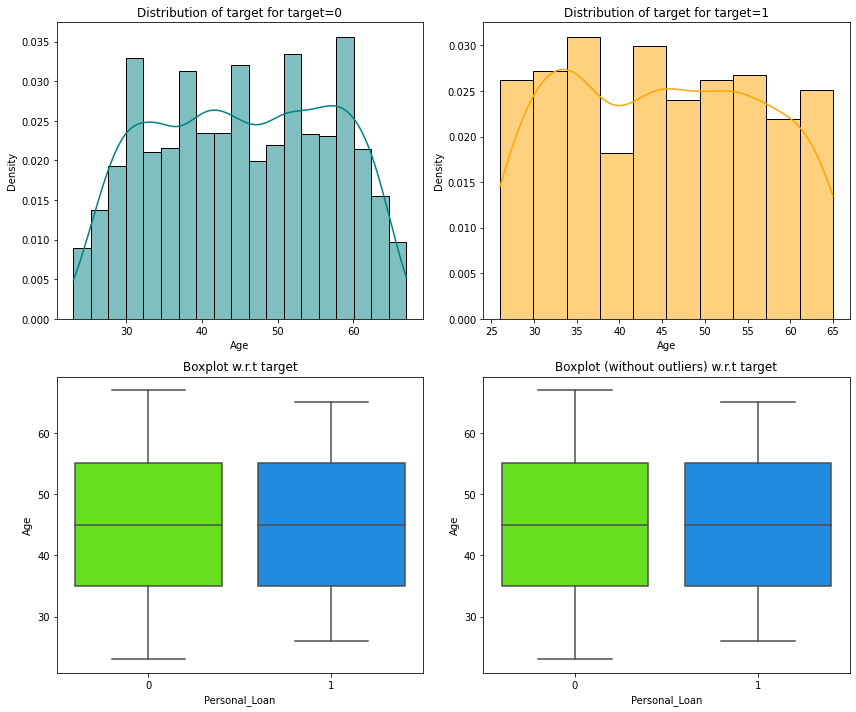

In [ ]:
distribution_plot_wrt_target(ploancp_df, "Age", "Personal_Loan")

Without Loans and w/o outliers: Notice that customers' age 30, 38, 46,52, and 58 are the most common.
With Loans and w/o outliers: Notice that 35 and 42 are the most common.  What could we determine? Not much.

Personal_Loan     0    1   All
Age                           
All            4520  480  5000
34              116   18   134
30              119   17   136
36               91   16   107
63               92   16   108
35              135   16   151
33              105   15   120
52              130   15   145
29              108   15   123
54              128   15   143
43              134   15   149
42              112   14   126
56              121   14   135
65               66   14    80
44              107   14   121
50              125   13   138
45              114   13   127
46              114   13   127
26               65   13    78
32              108   12   120
57              120   12   132
38              103   12   115
27               79   12    91
48              106   12   118
61              110   12   122
53              101   11   112
51              119   10   129
60              117   10   127
58              133   10   143
49              105   10   115
47      

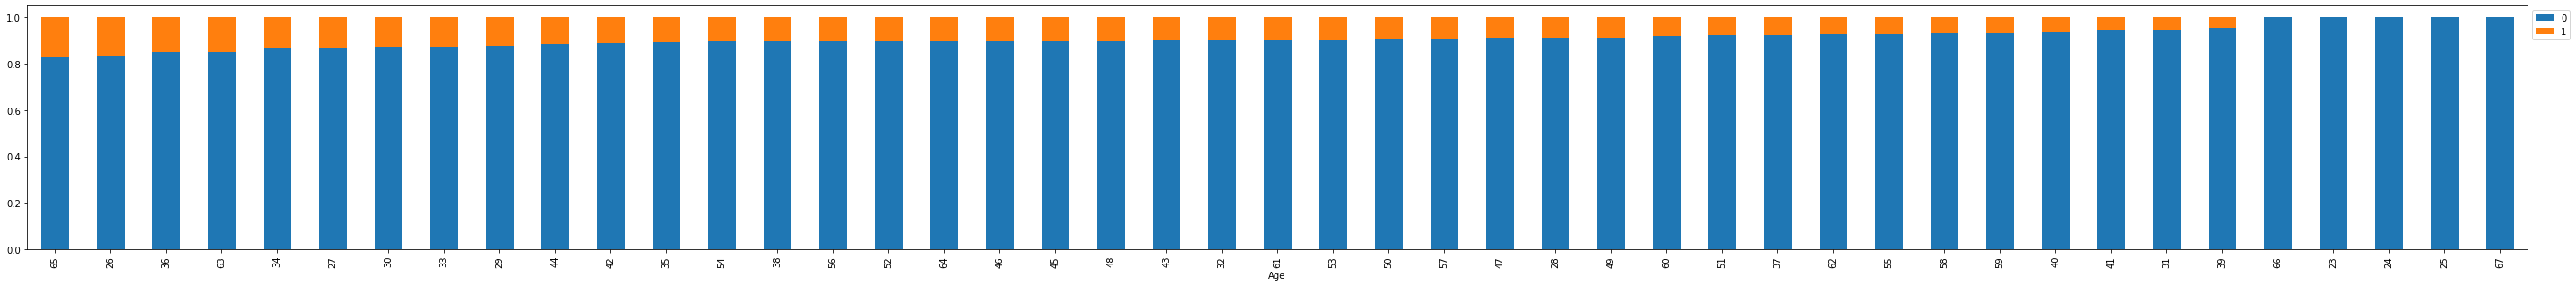

In [ ]:
stacked_barplot(ploancp_df, "Age", "Personal_Loan")

From the stacked plot we can see that customers aged 65, 26, 36, 63, 34, 27, 30, 33, 29 are the ones that have highest percentage of personal loans within their own age group.

Now notice that age 65 has the highest % of loans within its total, followed by 26, 36, 63, 34, 27, and 30. So 63+ group may have a larger chance to be loan customers. and also the group between 26-27 and 33-36.

### *Experience vs Age for Negative Experience*

During the univariate analysis we noticed that there are entries with Negative Experience, which of course are wrong values. 

We could replace Negative Experience with Median and Mode values, with zeros, or making the values positive and then analyze against other time dependant features like Age and Education.

In [ ]:
#case to mode/median
Experience_mode = ploancp_df['Experience'].mode()
print("Experience mode is", Experience_mode[0])
Experience_median = ploancp_df['Experience'].median()
print("Experience median is",Experience_median)

Experience mode is 32
Experience median is 20.0


In [ ]:
ploancp_negEx_df['modeX']= ploancp_negEx_df['Experience']-Experience_mode[0]
ploancp_negEx_df['medianX']= ploancp_negEx_df['Experience']-Experience_median

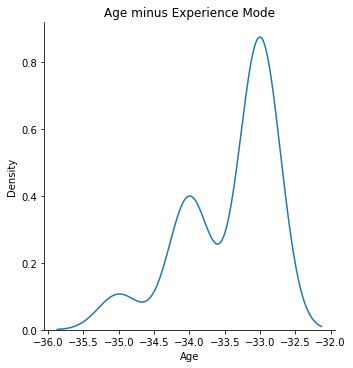

In [ ]:
sns.displot(ploancp_negEx_df, x="modeX", kind="kde")
plt.xlabel("Age")
plt.title("Age minus Experience Mode")
plt.show()

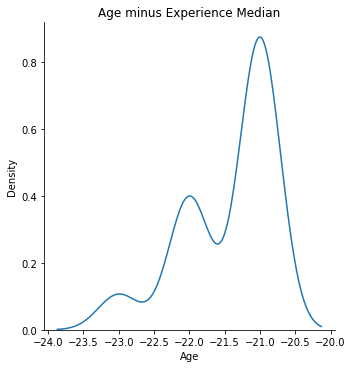

In [ ]:
sns.displot(ploancp_negEx_df, x="medianX", kind="kde")
plt.xlabel("Age")
plt.title("Age minus Experience Median")
plt.show()

So it wouldn't make any sense to change Experience=-3, -2, -1 to the mode or median. 

- Changing Negative experience to mode will produce Age < Experience! 
- Changing Negative experience to median would produce Ages between 3 to 9 years of age! 

Therefore, lets rule the Mode/Median Option.

Therefore, lets rule out these 2 options.


How about replacing Experience by 0?

In [ ]:
ploancp_x0_df = ploancp_df.loc[ploancp_df['Experience']<0]
ploancp_x0_df['Experience'] = 0
ploancp_x0_df

,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,Income_bin
89,25,0,113,94303,4,2.300,3,0,0,0,0,0,1,[100..125)
226,24,0,39,94085,2,1.700,2,0,0,0,0,0,0,[25..50)
315,24,0,51,90630,3,0.300,3,0,0,0,0,1,0,[50..75)
451,28,0,48,94132,2,1.750,3,89,0,0,0,1,0,[25..50)
524,24,0,75,93014,4,0.200,1,0,0,0,0,1,0,[50..75)
536,25,0,43,92173,3,2.400,2,176,0,0,0,1,0,[25..50)
540,25,0,109,94010,4,2.300,3,314,0,0,0,1,0,[100..125)
576,25,0,48,92870,3,0.300,3,0,0,0,0,0,1,[25..50)
583,24,0,38,95045,2,1.700,2,0,0,0,0,1,0,[25..50)
597,24,0,125,92835,2,7.200,1,0,0,1,0,0,1,[100..125)


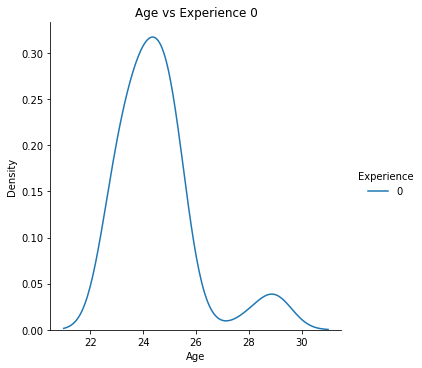

In [ ]:
#lets visualize age vs Experience when negative Experience is replaced by 0
sns.displot(ploancp_x0_df, x="Age", hue="Experience", kind="kde")
plt.title("Age vs Experience 0")
plt.show()

Notice : 29 years there -> 0 Experience.  Also, between 21 to 27 -> 0 Experience, being the largest around 24-25 -> 0 Experience.

In [ ]:
ploancp_x0_age_min_df = ploancp_x0_df['Age'].min()
ploancp_x0_age_median_df = ploancp_x0_df['Age'].median()
ploancp_x0_age_max_df = ploancp_x0_df['Age'].max()
print("For negative experience converted to 0, the minimum age is",ploancp_x0_age_min_df,
      ",the mean age is",ploancp_x0_age_median_df,
      ",the maximum age is",ploancp_x0_age_max_df)

For negative experience converted to 0, the minimum age is 23 ,the mean age is 24.0 ,the maximum age is 29


For Experience = 0
- min: 24, mean: 26, max: 30

For Negative Experience converted to 0
- min: 23, mean: 24m max: 29

Differences between Experience 0 and Converted to 0:
- min: 1, mean: 2, max: 1


How about converting negative experience to positive values, so for example a negative experience of -3 becomes 3? 

In [ ]:
#make all experience year positive
ploancp_negEx_df['allPosX']= ploancp_negEx_df['Experience'].abs()
ploancp_negEx_df

,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,modeX,medianX,allPosX
89,25,-1,113,94303,4,2.300,3,0,0,0,0,0,1,-33,-21.000,1
226,24,-1,39,94085,2,1.700,2,0,0,0,0,0,0,-33,-21.000,1
315,24,-2,51,90630,3,0.300,3,0,0,0,0,1,0,-34,-22.000,2
451,28,-2,48,94132,2,1.750,3,89,0,0,0,1,0,-34,-22.000,2
524,24,-1,75,93014,4,0.200,1,0,0,0,0,1,0,-33,-21.000,1
536,25,-1,43,92173,3,2.400,2,176,0,0,0,1,0,-33,-21.000,1
540,25,-1,109,94010,4,2.300,3,314,0,0,0,1,0,-33,-21.000,1
576,25,-1,48,92870,3,0.300,3,0,0,0,0,0,1,-33,-21.000,1
583,24,-1,38,95045,2,1.700,2,0,0,0,0,1,0,-33,-21.000,1
597,24,-2,125,92835,2,7.200,1,0,0,1,0,0,1,-34,-22.000,2


Lets see our results when we convert negative experience to its positive value. 

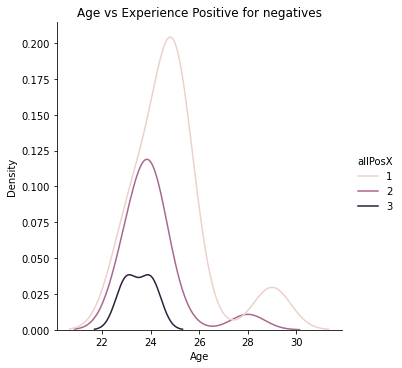

In [ ]:
#lets visualize age vs Experience when negative Experience is replaced by its positive value
sns.displot(ploancp_negEx_df, x="Age", hue="allPosX", kind="kde")
plt.title("Age vs Experience Positive for negatives")
plt.show()

If we converted the negative experience to Positive values, we notice 29 years -> 1 Experience, and a mostly around 25 years -> 1 Experience. We also notice that around 24 years -> 2 Experience, and at 28 years -> 2 Experience. Notice that around 23-24 years -> 3 Experience.

Does this make sense?


In [ ]:
#experience = 1
ploancp_x1_df = ploancp_df.loc[ploancp_df['Experience']==1]
x1_median=ploancp_x1_df['Age'].median()
x1_min=ploancp_x1_df['Age'].min()
x1_max=ploancp_x1_df['Age'].max()

ploancp_x1_df

,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,Income_bin
0,25,1,49,91107,4,1.600,1,0,0,1,0,0,0,[25..50)
132,31,1,51,90840,2,1.750,3,0,0,0,0,0,0,[50..75)
143,25,1,54,94117,4,1.600,1,0,0,0,0,1,1,[50..75)
165,27,1,43,94706,1,1.500,1,0,0,0,0,1,0,[25..50)
166,25,1,21,95827,3,1.000,2,0,0,0,0,0,0,[0..25)
169,27,1,112,90503,4,2.100,3,0,0,0,0,0,1,[100..125)
170,27,1,138,90250,2,2.000,1,0,0,0,0,1,0,[125..150)
234,26,1,80,95616,1,0.800,2,150,0,0,0,0,0,[75..100)
249,26,1,55,90089,3,2.600,3,113,0,0,0,0,1,[50..75)
263,27,1,74,92121,4,1.800,2,112,0,0,0,1,1,[50..75)


In [ ]:
print("For Experience 1, the minimum age is",x1_min,
      ",the mean age is",x1_median,
      ",the maximum age is",x1_max)

For Experience 1, the minimum age is 25 ,the mean age is 26.0 ,the maximum age is 31


In [ ]:
#experience = 2
ploancp_x2_df = ploancp_df.loc[ploancp_df['Experience']==2]
x2_median=ploancp_x2_df['Age'].median()
x2_min=ploancp_x2_df['Age'].min()
x2_max=ploancp_x2_df['Age'].max()

ploancp_x2_df

,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,Income_bin
58,28,2,93,94065,2,0.200,1,0,0,0,0,0,0,[75..100)
85,27,2,109,94005,4,1.800,3,0,0,0,0,0,0,[100..125)
222,26,2,104,94306,3,2.500,1,0,0,0,0,0,0,[100..125)
277,29,2,30,92126,4,1.000,3,0,0,0,0,0,0,[25..50)
318,27,2,110,95670,4,1.800,3,190,0,0,0,1,0,[100..125)
349,26,2,60,93407,2,3.000,1,132,1,0,0,0,0,[50..75)
397,26,2,48,90503,3,0.700,2,0,0,0,0,1,0,[25..50)
401,29,2,30,95747,4,1.500,2,112,0,0,0,0,1,[25..50)
526,26,2,205,93106,1,6.330,1,271,0,0,0,0,1,[200..225]
533,27,2,101,92807,1,1.900,1,0,0,0,0,0,0,[100..125)


In [ ]:
print("For Experience 2, the minimum age is",x2_min,
      ",the mean age is",x2_median,
      ",the maximum age is",x2_max)

For Experience 2, the minimum age is 26 ,the mean age is 27.0 ,the maximum age is 32


In [ ]:
#experience = 3
ploancp_x3_df = ploancp_df.loc[ploancp_df['Experience']==3]
x3_median=ploancp_x3_df['Age'].median()
x3_min=ploancp_x3_df['Age'].min()
x3_max=ploancp_x3_df['Age'].max()

ploancp_x3_df

,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,Income_bin
74,28,3,135,94611,2,3.300,1,0,0,0,0,0,1,[125..150)
177,29,3,65,94132,4,1.800,2,244,0,0,0,0,0,[50..75)
183,29,3,148,92173,3,4.100,1,0,1,0,0,1,0,[125..150)
198,27,3,59,94123,4,0.000,1,90,0,1,0,1,0,[50..75)
202,30,3,68,94306,4,2.000,2,0,0,0,0,1,0,[50..75)
216,27,3,125,95521,2,0.600,1,0,0,0,0,0,0,[100..125)
239,28,3,52,94112,4,1.700,2,0,0,0,0,0,0,[50..75)
272,29,3,45,95023,4,0.200,1,158,0,0,0,1,1,[25..50)
338,29,3,153,93657,2,2.000,1,392,0,0,0,0,0,[150..175)
399,28,3,84,90024,4,0.200,1,0,0,0,0,1,1,[75..100)


In [ ]:
print("For Experience 3, the minimum age is",x3_min,
      ",the mean age is",x3_median,
      ",the maximum age is",x3_max)

For Experience 3, the minimum age is 27 ,the mean age is 28.0 ,the maximum age is 33


In [ ]:
#for converted negative experience to positive
#experience = 3
ploancp_NegX_3_df = ploancp_negEx_df.loc[ploancp_negEx_df['allPosX']==3]
NegX3_median=ploancp_NegX_3_df['Age'].median()
NegX3_min=ploancp_NegX_3_df['Age'].min()
NegX3_max=ploancp_NegX_3_df['Age'].max()
print("For Negative Experience -3 to +3, the minimum age is",NegX3_min,
      ",the mean age is",NegX3_median,
      ",the maximum age is",NegX3_max)

For Negative Experience -3 to +3, the minimum age is 23 ,the mean age is 23.5 ,the maximum age is 24


In [ ]:
#for converted negative experience to positive
#experience = 2
ploancp_NegX_2_df = ploancp_negEx_df.loc[ploancp_negEx_df['allPosX']==2]
NegX2_median=ploancp_NegX_2_df['Age'].median()
NegX2_min=ploancp_NegX_2_df['Age'].min()
NegX2_max=ploancp_NegX_2_df['Age'].max()
print("For Negative Experience -2 to +2, the minimum age is",NegX2_min,
      ",the mean age is",NegX2_median,
      ",the maximum age is",NegX2_max)

For Negative Experience -2 to +2, the minimum age is 23 ,the mean age is 24.0 ,the maximum age is 28


In [ ]:
#for converted negative experience to positive
#experience = 1
ploancp_NegX_1_df = ploancp_negEx_df.loc[ploancp_negEx_df['allPosX']==1]
NegX1_median=ploancp_NegX_1_df['Age'].median()
NegX1_min=ploancp_NegX_1_df['Age'].min()
NegX1_max=ploancp_NegX_1_df['Age'].max()
print("For Negative Experience -1 to +1, the minimum age is",NegX1_min,
      ",the mean age is",NegX1_median,
      ",the maximum age is",NegX1_max)

For Negative Experience -1 to +1, the minimum age is 23 ,the mean age is 25.0 ,the maximum age is 29


Comparing to the case when we converted negative experiences to 0 to the actual positive values:

Actual 1: min: 25, mean: 26, max: 31

Converted 1: min: 23, mean: 25, max: 29

Differences 1-Actual-Converted: min: 2, mean: 1, max: 2
************************************

Actual 2: min: 26, mean: 27, max: 32

Converted 2: min: 23, mean: 24, max: 28

Differences 2-Actual-Converted: min: 3, mean: 3, max: 4
************************************

Actual 3: min: 27, mean: 28, max: 33

Converted 3: min: 23, mean: 23.5, max: 24

Differences 2-Actual-Converted: min: 4, mean: 4.5, max: 9


Comparing Converting Negative Experience to 0 or Converting to their positive values, we notice that the minimum, median, and maximum ages for the case of Negative Experience converted to 0 are more similar to the actual Experience =0 of the dataset than the minimum, median, and maximum ages if we would convert negative experiences to their respective positive values and compare them to the actual corresponding positive Experience values of the dataset.

Therefore, we choose to convert negative Experience values to 0.

In [ ]:
ploancp_df.loc[ploancp_df['Experience'] < 0, 'Experience'] = 0

### Experience vs Personal Loan

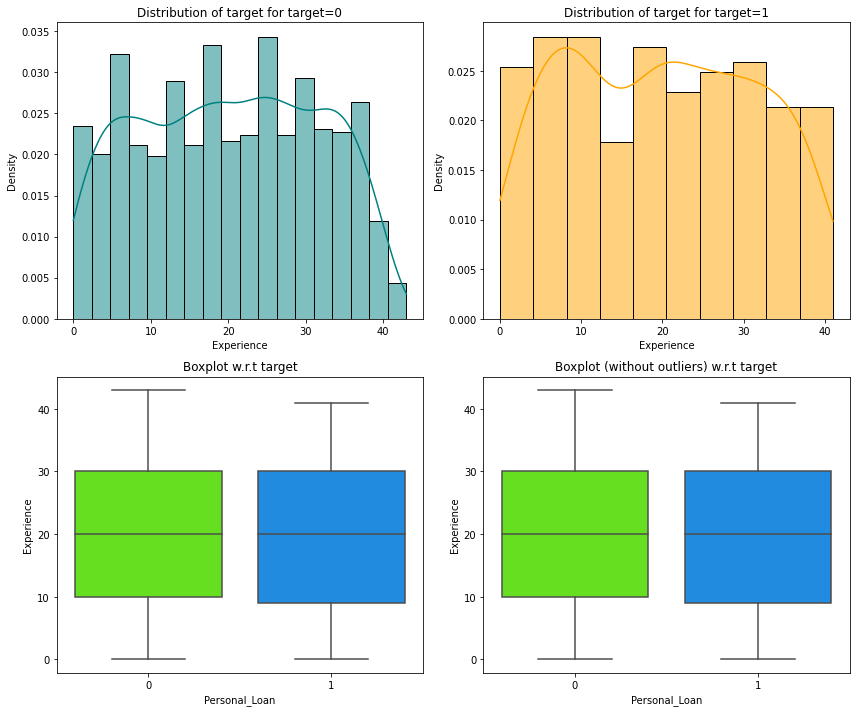

In [ ]:
distribution_plot_wrt_target(ploancp_df, "Experience", "Personal_Loan")

Notice that Personal Loan Customers have largest amount of common experience at 5 to 12 years, 18-20 years, and around 30 years.
Customers w/o Loans have largest amount of common experiences at 7-8, 18-19, 24-26 years.

### *Income vs Personal Loan*

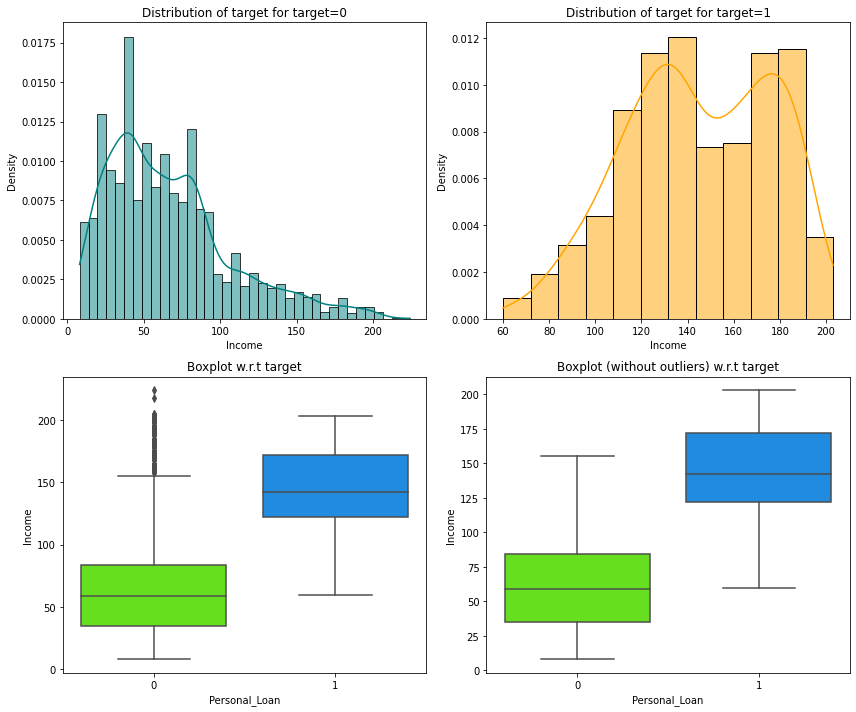

In [ ]:
distribution_plot_wrt_target(ploancp_df, "Income", "Personal_Loan")

Personal Loan customers have largest common amount of income 120-140K, and 170-190K.  Customers w/o Personal Loans have largest common amount of income 45K.

Personal_Loan     0    1   All
Income                        
All            4520  480  5000
130               8   11    19
182               2   11    13
158               8   10    18
135               8   10    18
179               8    9    17
141              15    9    24
154              12    9    21
123               9    9    18
184               3    9    12
142               7    8    15
131              11    8    19
129              15    8    23
172               3    8    11
173               5    8    13
170               4    8    12
180              10    8    18
115              19    8    27
125              16    7    23
164               6    7    13
188               3    7    10
83               67    7    74
114              23    7    30
161               9    7    16
122              17    7    24
133               8    7    15
132              11    7    18
191               6    7    13
134              13    7    20
111              15    7    22
190     

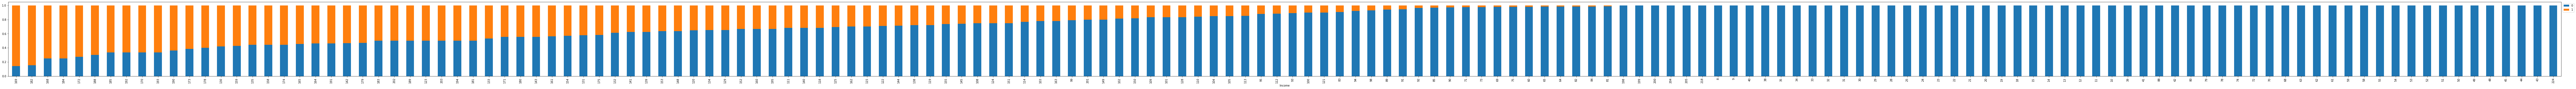

In [ ]:
stacked_barplot(ploancp_df, "Income", "Personal_Loan")

Notice that 170K, 182K, 168K, 184K, 172K, 188K, 185K, 192K are the groups that have a largest percentages of Personal Loans within their group.


### *ZIPCode vs Personal Loan*

Where are the majority of customers?

In [ ]:
#for the number of accounts
ziploan = ploancp_df[['ZIPCode','Personal_Loan']]
ziploan_count = ziploan['ZIPCode'].value_counts()
ziploan_count_df= pd.DataFrame(ziploan_count)
ziploan_count_df.reset_index(inplace=True)
ziploan_count_df = ziploan_count_df.rename(columns={'ZIPCode': 'NoAccounts', 'index': 'ZIPCode'})
ziploan_count_descending_df = ziploan_count_df.sort_values(['NoAccounts'],ascending=False)
ziploan_count_descending_df

,ZIPCode,NoAccounts
0,94720,169
1,94305,127
2,95616,116
3,90095,71
4,93106,57
...,...,...
460,92694,1
459,90068,1
457,90813,1
456,94404,1


The majority of customers (10%) are in 5 zip codes: 94720, 94305, 95616, 90095, 93106, all corresponding to states in the West coast: California, Oregon, and Washington. 

Lets dig into this a bit more.

Does the ZIP code influence whether a personal loan is taken?

How about comparing the number of loans in a ZIP code as a percentage of the total number of loans in the dataset, or the number of accounts in a ZIP code as a percentage of the total number of accounts in the dataset?

In [ ]:
ziploan_count_descending_df.head(10)

,ZIPCode,NoAccounts
0,94720,169
1,94305,127
2,95616,116
3,90095,71
4,93106,57
5,93943,54
6,92037,54
7,91320,53
8,91711,52
9,94025,52


In [ ]:
#for the number of loans
ziploanpl = ploancp_df[ploancp_df['Personal_Loan']== True]
number_loans = ziploanpl['Personal_Loan'].value_counts()
ziploanpl_count = ziploanpl['ZIPCode'].value_counts()
ziploanpl_count_df = pd.DataFrame(ziploanpl_count)
ziploanpl_count_df.reset_index(inplace=True)
ziploanpl_count_df = ziploanpl_count_df.rename(columns={'ZIPCode': 'PLoans', 'index': 'ZIPCode'})

In [ ]:
#calculating the percentages
zipLoanTrue = pd.merge(ziploan_count_df, ziploanpl_count_df, on ='ZIPCode')
zipLoanTrue['PercentLoans'] = (zipLoanTrue['PLoans']/number_loans[1])
zipLoanTrue['PercentAccounts']= (zipLoanTrue['NoAccounts']/number_accounts)

#sort in descending order for number of Loans
zipLoanTrue_descending_df = zipLoanTrue.sort_values(['PLoans'],ascending=False)
zipLoanTrue_descending_df.head(20)

,ZIPCode,NoAccounts,PLoans,PercentLoans,PercentAccounts
0,94720,169,19,0.040,0.034
1,94305,127,13,0.027,0.025
10,92093,51,9,0.019,0.010
16,94304,45,8,0.017,0.009
3,90095,71,8,0.017,0.014
13,90089,46,8,0.017,0.009
20,92182,32,7,0.015,0.006
35,94022,25,6,0.013,0.005
2,95616,116,6,0.013,0.023
18,95051,34,6,0.013,0.007


In [ ]:
#sort in descending order for % of accounts out of total number
zipLoanTrue_descending_df = zipLoanTrue.sort_values(['PercentAccounts'],ascending=False)
zipLoanTrue_descending_df.head(50)

,ZIPCode,NoAccounts,PLoans,PercentLoans,PercentAccounts
0,94720,169,19,0.040,0.034
1,94305,127,13,0.027,0.025
2,95616,116,6,0.013,0.023
3,90095,71,8,0.017,0.014
4,93106,57,4,0.008,0.011
5,93943,54,4,0.008,0.011
6,92037,54,5,0.010,0.011
7,91320,53,2,0.004,0.011
8,91711,52,4,0.008,0.010
9,94025,52,4,0.008,0.010


We can focus in zip codes that have more than 1 personal loans

In [ ]:
zipLoanTrue_descending_loan2_df = zipLoanTrue_descending_df.loc[zipLoanTrue_descending_df['PLoans']>=2]
zipLoanTrue_descending_loan2_df

,ZIPCode,NoAccounts,PLoans,PercentLoans,PercentAccounts
0,94720,169,19,0.040,0.034
1,94305,127,13,0.027,0.025
2,95616,116,6,0.013,0.023
3,90095,71,8,0.017,0.014
4,93106,57,4,0.008,0.011
5,93943,54,4,0.008,0.011
6,92037,54,5,0.010,0.011
7,91320,53,2,0.004,0.011
8,91711,52,4,0.008,0.010
9,94025,52,4,0.008,0.010


ZIP Code 94720 has 19 PL, 94305 has 13 PL, 92093 has 9 PL, 90095, 94304, 90089 have 8 PL, 92182 has 7 PL, 94022, 95051, 95616 have 6 PL, 95054, 95814, 92037, 90245, 94928,91380	have 5 PL

ZIP Code 94720 is the UC Berkeley campus.

ZIP Code 94305 contains the Stanford Univ campus.

ZIP Code 92093 contains the UC Santa Clara and U San Diego campus

ZIP Code 90095: contains UCLA

ZIP Code 94304: Palo Alto, CA close to Stanford

ZIP Code 90089: contains USC or very near to USC

ZIP Code 92182: contains San Diego State Univ.

ZIP Code 94022: this zip code also has many schools, like Palo Alto University, Foothill College, etc.

ZIP Code 95051: Mission College, Santa Clara Univ, etc.

ZIP Code 95616: UC at Davis

ZIP Code 95054: Santa Clara, CA

ZIP Code 95814: Sacramento, CA

ZIP Code 92037: La Jolla, CA

ZIP Code 90245: El Segundo, CA

ZIP Code 94928,

ZIP Code 91380

Is this a clue that college students take out loans, which would mean that customers that are in college zip codes, are more likely than to take a loan than customers that are not in college?

We can later take a look at the age group to see if these match a profile of a student age (beware of non-traditional students). However because many of the ZIP codes are in school areas, there could be some kind of association with the schools (faculty, or be a post-graduate student, or work there for example or even be a non-traditional student). They also seem to be mostly experienced, have large incomes.

### *Family vs Personal Loan*

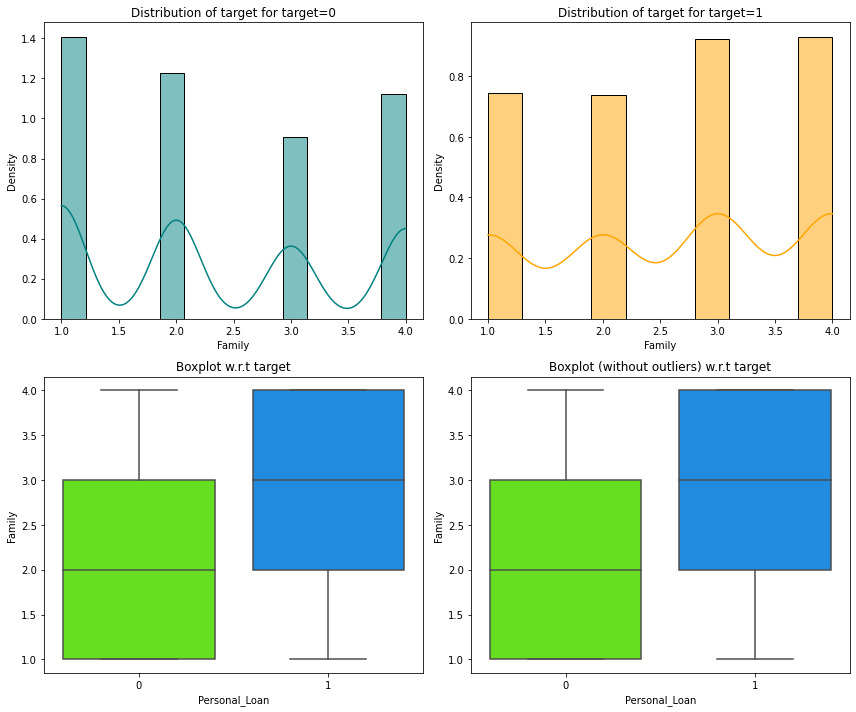

In [ ]:
distribution_plot_wrt_target(ploancp_df, "Family", "Personal_Loan")

Notice that customers with 3 and 4 family members have more Personal Loans.

Personal_Loan     0    1   All
Family                        
All            4520  480  5000
4              1088  134  1222
3               877  133  1010
1              1365  107  1472
2              1190  106  1296
------------------------------------------------------------------------------------------------------------------------


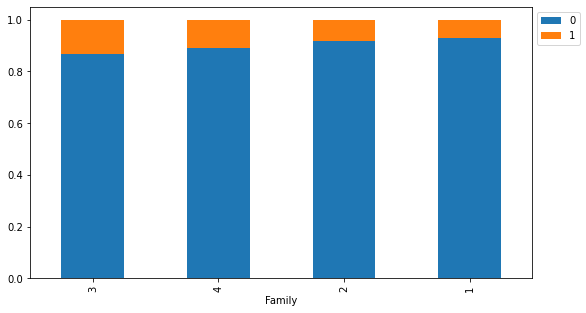

In [ ]:
stacked_barplot(ploancp_df, "Family", "Personal_Loan")

Family size 4 have the largest amount of Personal Loan and the highest percentage within its group. Family size 3 have the second largest percentage within its group.

### *Credit Card Average Expenses vs Personal Loan*

***Credit Card Average as Year Income Percentage vs Personal Loan***

In [ ]:
#lets create a new column to represent the % of CCAVg per month over Average monthly Income.
ploancp_df['CCAvg_Inc%']=(ploancp_df['CCAvg']*100/(ploancp_df['Income']/12))
ploancp_df['CCAvg_Inc%']

0       39.184
1       52.941
2      109.091
3       32.400
4       26.667
         ...  
4995    57.000
4996    32.000
4997    15.000
4998    12.245
4999    11.566
Name: CCAvg_Inc%, Length: 5000, dtype: float64

Credit card usage as a percentage of Income is more meaningful than an absolute value.

In [ ]:
ploancp_df['CCAvg_Inc%'].value_counts()
ploancp_df['CCAvg_Inc%'].max()
ploancp_df['CCAvg_Inc%'].min()

0.0

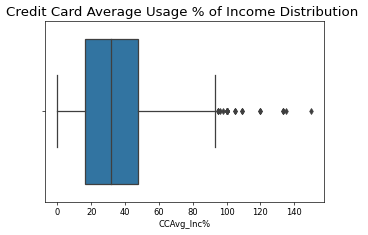

In [ ]:
plt.figure(figsize=(6,4), dpi= 60)
plt.title("Credit Card Average Usage % of Income Distribution ", fontsize=16)
sns.boxplot(data=ploancp_df,x='CCAvg_Inc%')
plt.show()

Notice the outliers above 90% monthly income expense in monthly credit card usage.

So lets drop the credit card Usage CCAvg field.

We should however later take a look in the bivariate analysis, of how Credit card usage looks against Personal Loans.

In [ ]:
ploancp_df.drop('CCAvg', axis=1, inplace=True)

Maybe we can create bins to simplify our analysis?


Lets create bins of every 10%

In [ ]:
bins = [-0.1, 0, 10, 20, 30,40, 50, 60,70,80, 90, 100, 110, 120, 130, 140, 150]
labels = [0, 10, 20, 30,40, 50, 60,70,80, 90, 100, 110, 120, 130, 140, 150]
ploancp_df['CCAvg_Inc%_bin'] = pd.cut(ploancp_df['CCAvg_Inc%'], bins=bins, labels=labels)
print (ploancp_df)

      Age  Experience  Income ZIPCode  Family Education  Mortgage  \
0      25           1      49   91107       4         1         0   
1      45          19      34   90089       3         1         0   
2      39          15      11   94720       1         1         0   
3      35           9     100   94112       1         2         0   
4      35           8      45   91330       4         2         0   
...   ...         ...     ...     ...     ...       ...       ...   
4995   29           3      40   92697       1         3         0   
4996   30           4      15   92037       4         1        85   
4997   63          39      24   93023       2         3         0   
4998   65          40      49   90034       3         2         0   
4999   28           4      83   92612       3         1         0   

     Personal_Loan Securities_Account CD_Account Online CreditCard Income_bin  \
0                0                  1          0      0          0   [25..50)   
1        

In [ ]:
ploancp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Age                 5000 non-null   int64   
 1   Experience          5000 non-null   int64   
 2   Income              5000 non-null   int64   
 3   ZIPCode             5000 non-null   object  
 4   Family              5000 non-null   int64   
 5   Education           5000 non-null   object  
 6   Mortgage            5000 non-null   int64   
 7   Personal_Loan       5000 non-null   object  
 8   Securities_Account  5000 non-null   object  
 9   CD_Account          5000 non-null   object  
 10  Online              5000 non-null   object  
 11  CreditCard          5000 non-null   object  
 12  Income_bin          5000 non-null   category
 13  CCAvg_Inc%          5000 non-null   float64 
 14  CCAvg_Inc%_bin      5000 non-null   category
dtypes: category(2), float64(1), int64(5), 

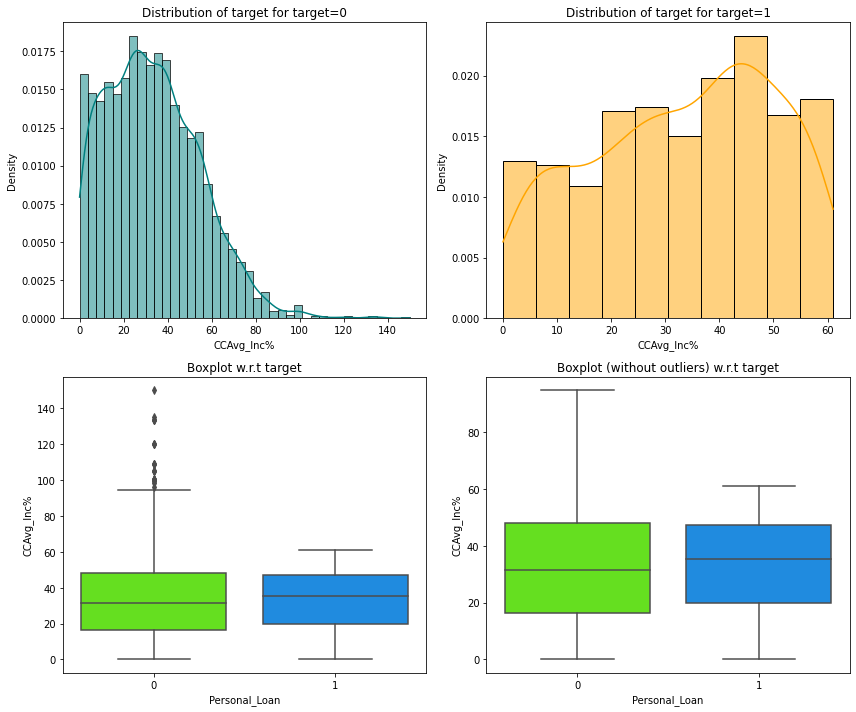

In [ ]:
distribution_plot_wrt_target(ploancp_df, "CCAvg_Inc%","Personal_Loan")

***Credit Card Average as year Income Percentage Bins vs Personal Loan***

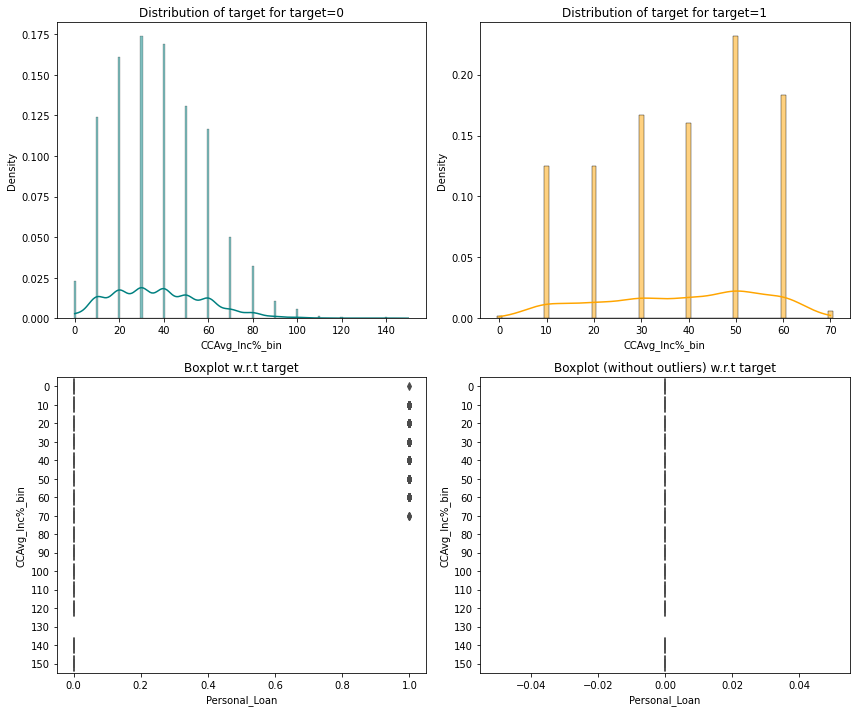

In [ ]:
distribution_plot_wrt_target(ploancp_df, "CCAvg_Inc%_bin","Personal_Loan")

Personal_Loan      0    1   All
CCAvg_Inc%_bin                 
All             4520  480  5000
50               590  111   701
60               526   88   614
30               785   80   865
40               764   77   841
10               562   60   622
20               727   60   787
70               227    3   230
0                105    1   106
80               146    0   146
90                48    0    48
100               25    0    25
110                7    0     7
120                3    0     3
140                4    0     4
150                1    0     1
------------------------------------------------------------------------------------------------------------------------


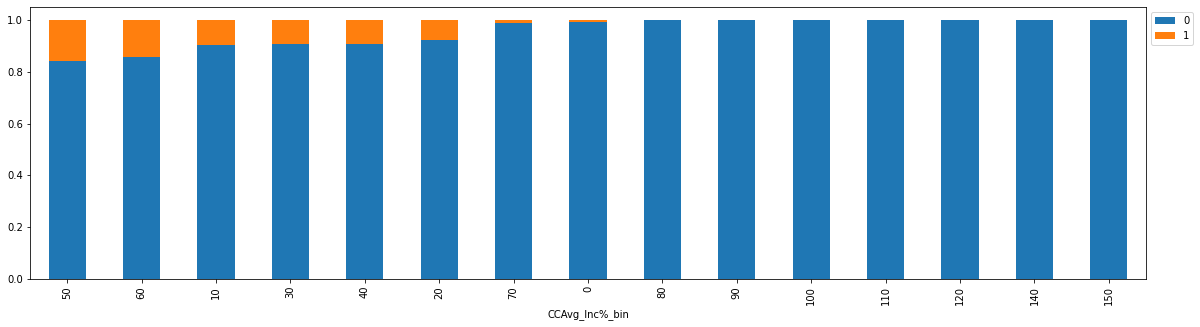

In [ ]:
stacked_barplot(ploancp_df, "CCAvg_Inc%_bin", "Personal_Loan")

Notice that customers with average 40-50% credit card usage as % of their monthly income have more Personal Loans than the rest.

Customers that have 50%, 60% of Credit card expenses as a % of their monthly income, also have the largest % of Personal Loans within their group.

### *Education vs Personal Loan*

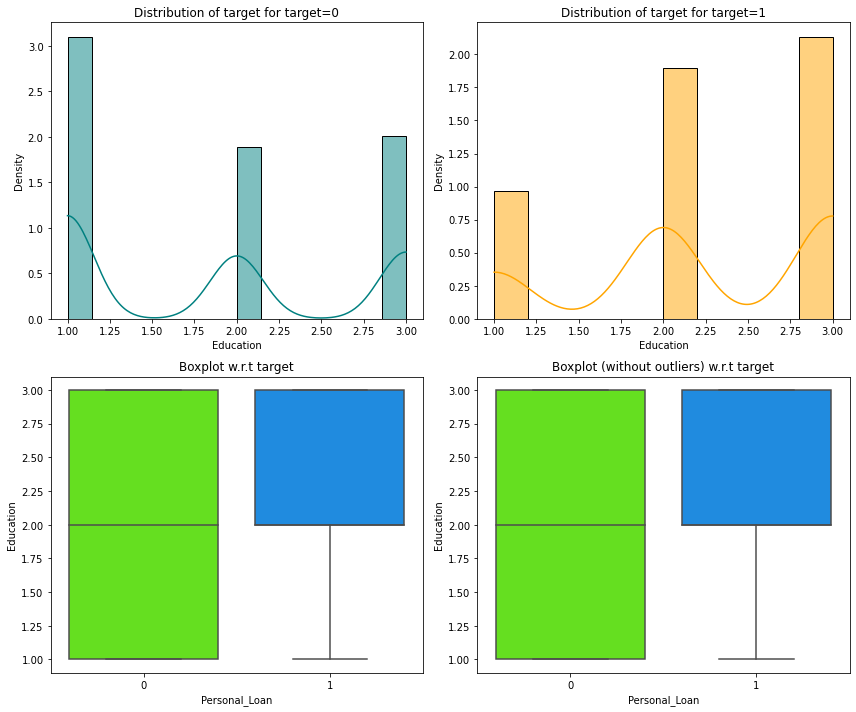

In [ ]:
distribution_plot_wrt_target(ploancp_df, "Education", "Personal_Loan")

Personal_Loan     0    1   All
Education                     
All            4520  480  5000
3              1296  205  1501
2              1221  182  1403
1              2003   93  2096
------------------------------------------------------------------------------------------------------------------------


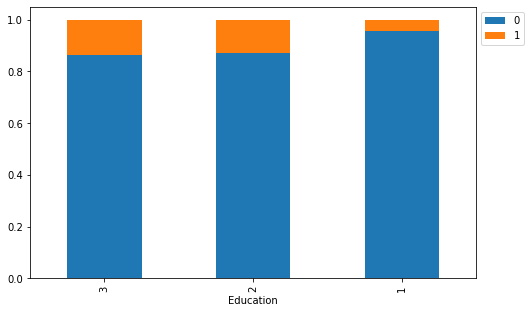

In [ ]:
stacked_barplot(ploancp_df, "Education", "Personal_Loan")

On Education, we can see that Customers with Advanced/Professional education take more Personal Loans than customers w/ graduate education. Customers with Graduate education take more loans than customers with undegraduate education.

Assuming that an Advanced Degree/Professional Degree is more education than a Graduate Degree, we can confidently claim that the more Education, the more Loans customers get.

### *Mortgage vs Personal Loan*

How about Mortgage as a % of Income?

In [ ]:
#lets create a new column to represent the % of Mortage over yearly Income.
ploancp_df['Mortgage_Inc%']=(ploancp_df['Mortgage']*100/ploancp_df['Income'])
ploancp_df['Mortgage_Inc%']

0        0.000
1        0.000
2        0.000
3        0.000
4        0.000
         ...  
4995     0.000
4996   566.667
4997     0.000
4998     0.000
4999     0.000
Name: Mortgage_Inc%, Length: 5000, dtype: float64

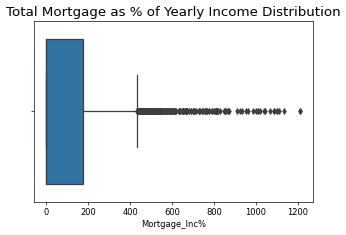

In [ ]:
#Mortage Distribution as a % of Yearly Income
plt.figure(figsize=(6,4), dpi= 60)
plt.title("Total Mortgage as % of Yearly Income Distribution", fontsize=16)
sns.boxplot(data=ploancp_df,x='Mortgage_Inc%')
plt.show()

Because Mortgages are spread through long periods of 20-30 years, the % will be very high. However, what if we dare to see the mortgage as a % of yearly income matched to mortgage yearly cost (simple w/o annuities, amortizations, etc)?

According to Google, the average length of a Mortgage is 30 years.

In [ ]:
#lets create a new column to represent the % of yearly Mortage over yearly Income.
ploancp_df['year_Mortgage_Inc%']=((ploancp_df['Mortgage']/30)*100/ploancp_df['Income'])
ploancp_df['year_Mortgage_Inc%']

0       0.000
1       0.000
2       0.000
3       0.000
4       0.000
        ...  
4995    0.000
4996   18.889
4997    0.000
4998    0.000
4999    0.000
Name: year_Mortgage_Inc%, Length: 5000, dtype: float64

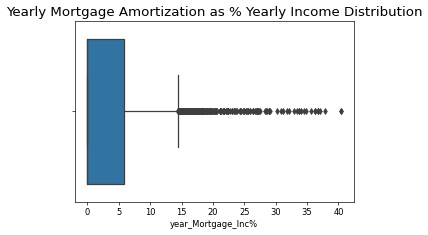

In [ ]:
#Yearly Mortage Distribution as a % of Yearly Income
plt.figure(figsize=(6,4), dpi= 60)
plt.title("Yearly Mortgage Amortization as % Yearly Income Distribution", fontsize=16)
sns.boxplot(data=ploancp_df,x='year_Mortgage_Inc%')
plt.show()

***Mortgage as Yearly Income Percentage vs Personal Loan***



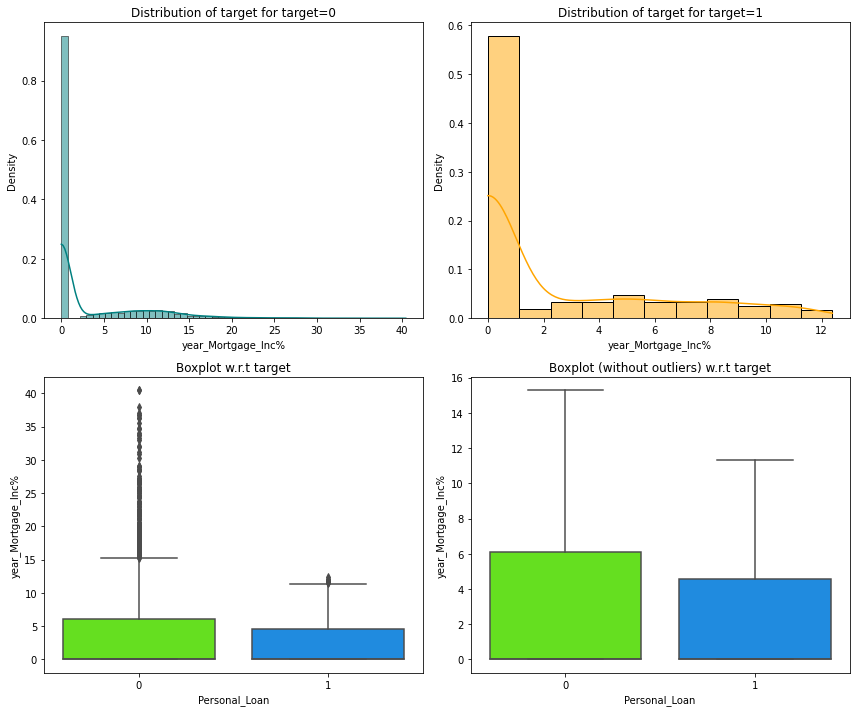

In [ ]:
distribution_plot_wrt_target(ploancp_df, "year_Mortgage_Inc%","Personal_Loan")

***Mortgage as Yearly Income Percentage Bins vs Personal Loan***

In [ ]:
bins = [-0.1,0, 5, 10, 15, 20,25, 30, 35,40,45]
labels = [0, 5, 10, 15, 20,25, 30, 35,40,45]
ploancp_df['year_Mortage_Inc%_bin'] = pd.cut(ploancp_df['year_Mortgage_Inc%'], bins=bins, labels=labels)
print (ploancp_df)

      Age  Experience  Income ZIPCode  Family Education  Mortgage  \
0      25           1      49   91107       4         1         0   
1      45          19      34   90089       3         1         0   
2      39          15      11   94720       1         1         0   
3      35           9     100   94112       1         2         0   
4      35           8      45   91330       4         2         0   
...   ...         ...     ...     ...     ...       ...       ...   
4995   29           3      40   92697       1         3         0   
4996   30           4      15   92037       4         1        85   
4997   63          39      24   93023       2         3         0   
4998   65          40      49   90034       3         2         0   
4999   28           4      83   92612       3         1         0   

     Personal_Loan Securities_Account CD_Account Online CreditCard Income_bin  \
0                0                  1          0      0          0   [25..50)   
1        

In [ ]:
#ploancp_df['year_Mortage_Inc%_bin']
ploancp_df['year_Mortage_Inc%_bin'] = ploancp_df['year_Mortage_Inc%_bin'].astype('int')


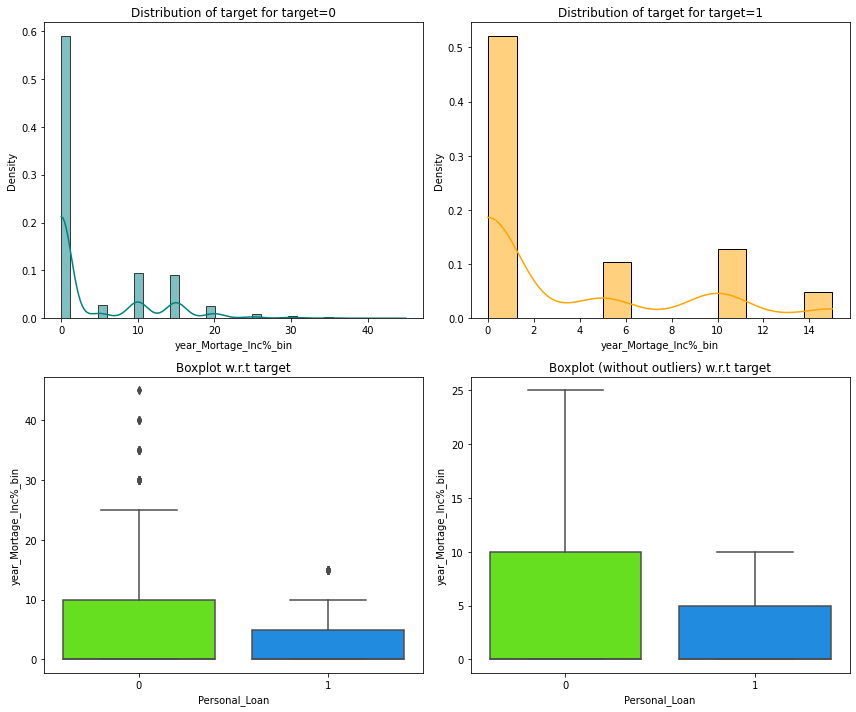

In [ ]:
distribution_plot_wrt_target(ploancp_df, "year_Mortage_Inc%_bin","Personal_Loan")

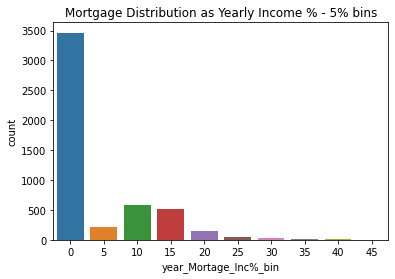

In [ ]:
sns.countplot(ploancp_df["year_Mortage_Inc%_bin"])
plt.title("Mortgage Distribution as Yearly Income % - 5% bins")
plt.show()

We notice that there is a customer that pays more than 40% of his/her yearly income in mortage. But we will analyze this in the bivariate analysis better.

Now Lets drop the columns 'Mortgage' and 'Mortgage_Inc%"

In [ ]:
ploancp_df.drop(['Mortgage','Mortgage_Inc%'], axis=1, inplace=True)

In [ ]:
#lets look at the mortage
ploancp_df['year_Mortgage_Inc%'].value_counts()

0.000     3462
10.000       5
14.545       5
11.429       4
4.667        4
          ... 
5.805        1
10.000       1
24.524       1
10.397       1
18.889       1
Name: year_Mortgage_Inc%, Length: 1392, dtype: int64

In [ ]:
ploancp_df['year_Mortgage_Inc%'].max()
ploancp_df['year_Mortgage_Inc%'].min()

0.0

lets bin the mortages

Personal_Loan             0    1   All
year_Mortage_Inc%_bin                 
All                    4520  480  5000
0                      3150  312  3462
10                      504   77   581
5                       149   62   211
15                      484   29   513
20                      143    0   143
25                       43    0    43
30                       26    0    26
35                       12    0    12
40                        7    0     7
45                        2    0     2
------------------------------------------------------------------------------------------------------------------------


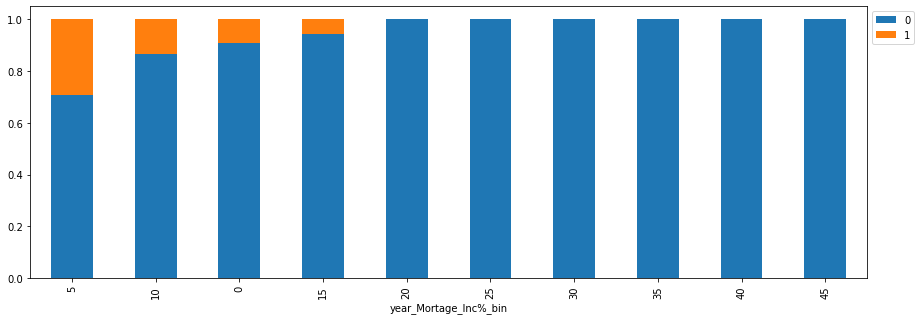

In [ ]:
stacked_barplot(ploancp_df, "year_Mortage_Inc%_bin", "Personal_Loan")

Notice that customers that have mortgages and that mortage is 5%-10% of their yearly income have the largest % of personal loans

### *Securities Account vs Personal Loan*

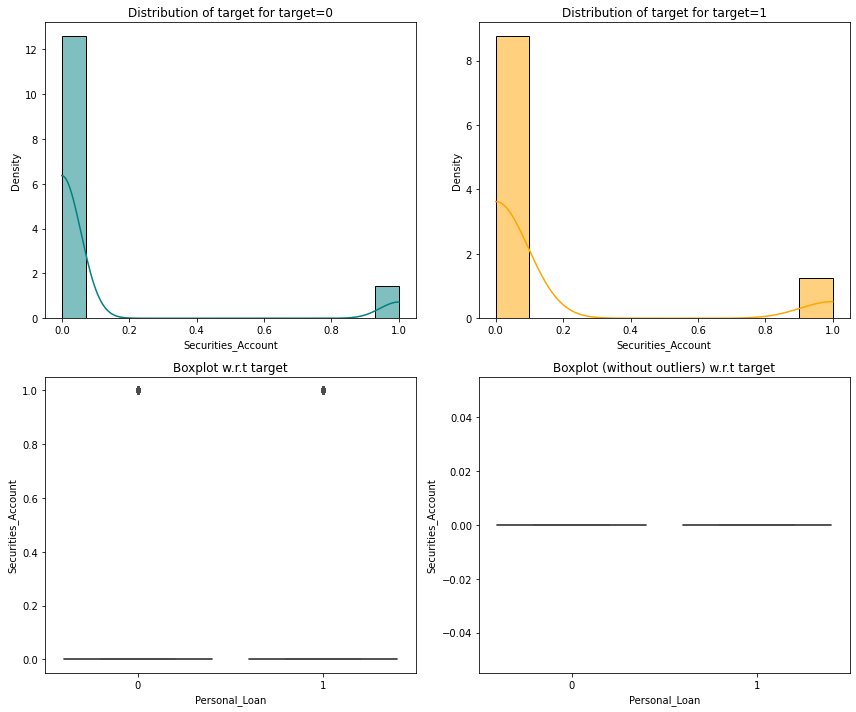

In [ ]:
distribution_plot_wrt_target(ploancp_df, "Securities_Account", "Personal_Loan")

Personal_Loan          0    1   All
Securities_Account                 
All                 4520  480  5000
0                   4058  420  4478
1                    462   60   522
------------------------------------------------------------------------------------------------------------------------


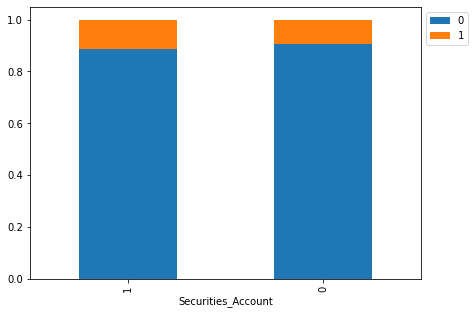

In [ ]:
stacked_barplot(ploancp_df, "Securities_Account", "Personal_Loan")

Customers with Securities Account have a slightly largest % of personal Loans within their group.

### *CD Account vs Personal Loan*

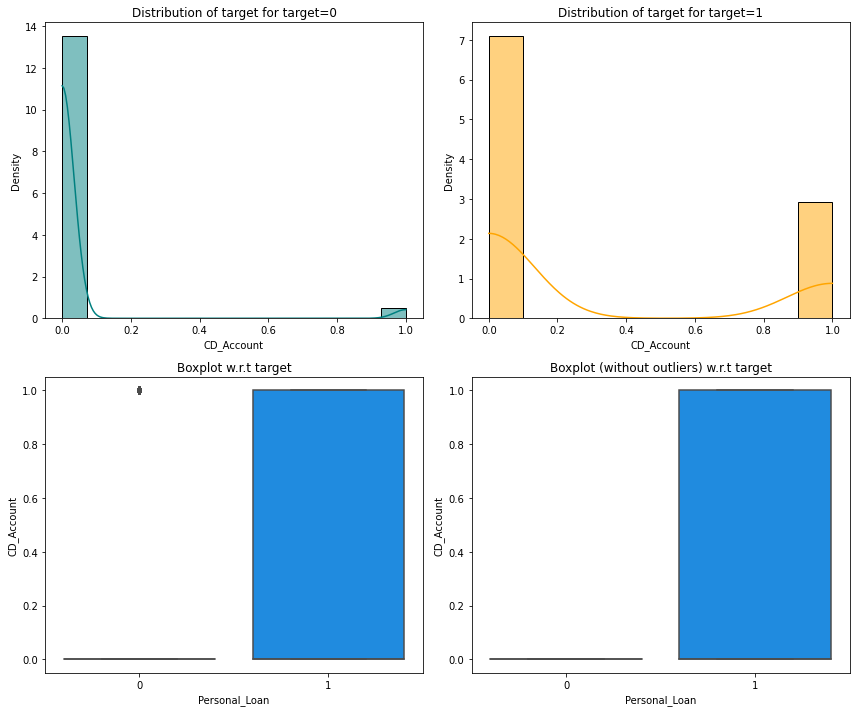

In [ ]:
distribution_plot_wrt_target(ploancp_df, "CD_Account", "Personal_Loan")

Personal_Loan     0    1   All
CD_Account                    
All            4520  480  5000
0              4358  340  4698
1               162  140   302
------------------------------------------------------------------------------------------------------------------------


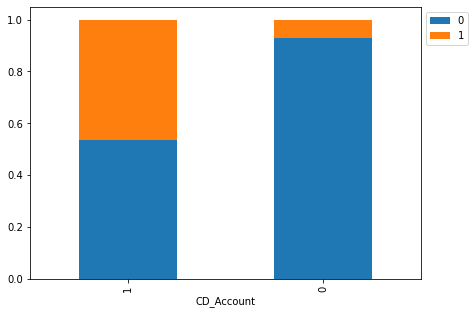

In [ ]:
stacked_barplot(ploancp_df, "CD_Account", "Personal_Loan")

Customers with CD Accounts also tend to have more Personal Loans % within their group than customers w/o a CD Account. 

### *Online vs Personal Loan*

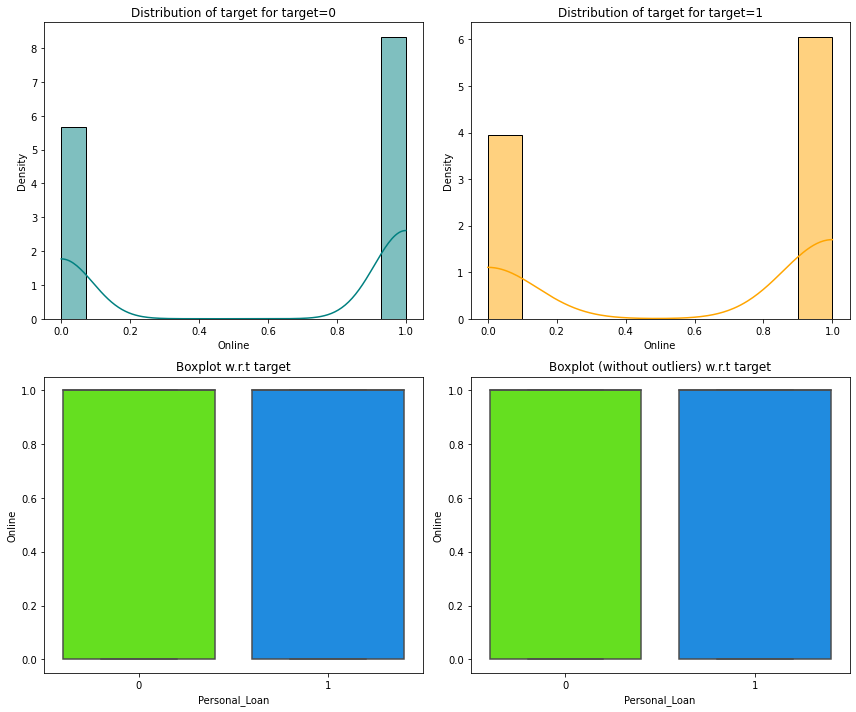

In [ ]:
distribution_plot_wrt_target(ploancp_df, "Online", "Personal_Loan")

Personal_Loan     0    1   All
Online                        
All            4520  480  5000
1              2693  291  2984
0              1827  189  2016
------------------------------------------------------------------------------------------------------------------------


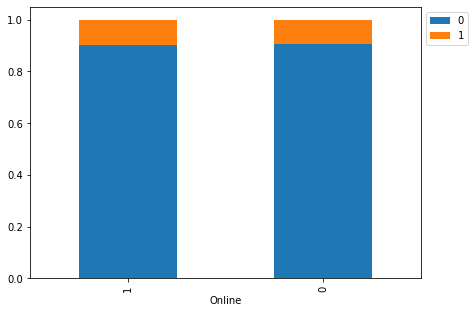

In [ ]:
stacked_barplot(ploancp_df, "Online", "Personal_Loan")

Customers that use Online access and customers that don't use Online access are very similar in  the amount of Personal Loans.

### *Credit Card vs Personal Loan*

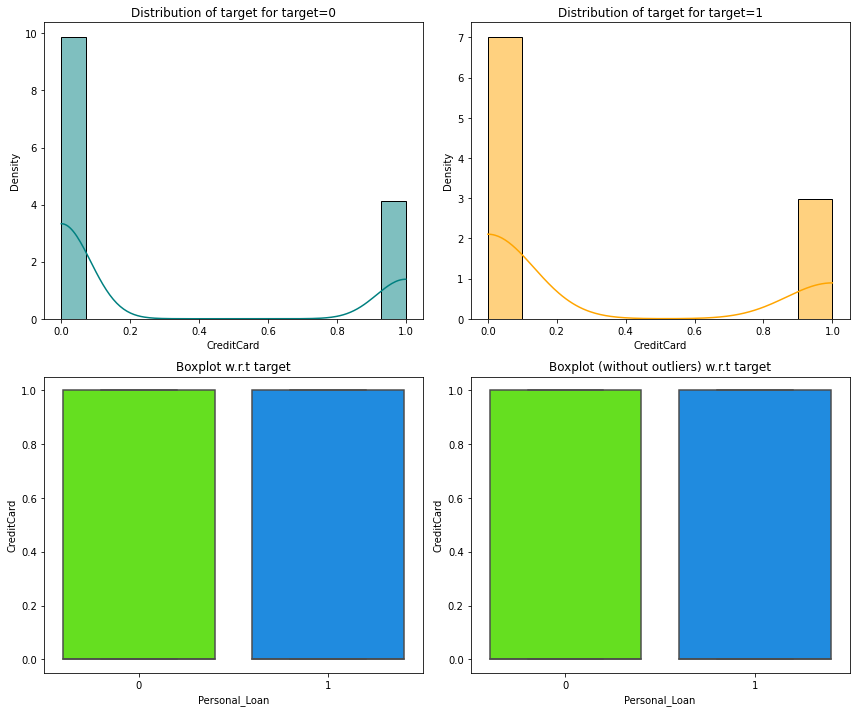

In [ ]:
distribution_plot_wrt_target(ploancp_df, "CreditCard", "Personal_Loan")

Personal_Loan     0    1   All
CreditCard                    
All            4520  480  5000
0              3193  337  3530
1              1327  143  1470
------------------------------------------------------------------------------------------------------------------------


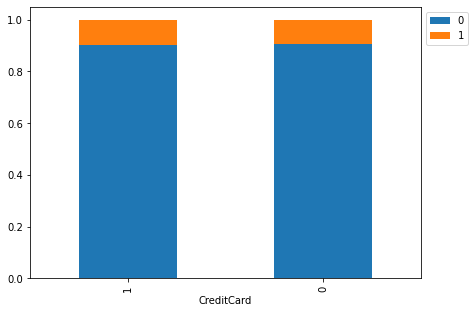

In [ ]:
stacked_barplot(ploancp_df, "CreditCard", "Personal_Loan")

There are more customers w/o a Credit Card that have a Personal Loans than those with a credit card. However, percentage wise within their group, a larger % within their group of Customers that have Credit cards than those w/o credit cards. 

# Second Data Preparation

In [ ]:
ploancp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Age                    5000 non-null   int64   
 1   Experience             5000 non-null   int64   
 2   Income                 5000 non-null   int64   
 3   ZIPCode                5000 non-null   object  
 4   Family                 5000 non-null   int64   
 5   Education              5000 non-null   object  
 6   Personal_Loan          5000 non-null   object  
 7   Securities_Account     5000 non-null   object  
 8   CD_Account             5000 non-null   object  
 9   Online                 5000 non-null   object  
 10  CreditCard             5000 non-null   object  
 11  Income_bin             5000 non-null   category
 12  CCAvg_Inc%             5000 non-null   float64 
 13  CCAvg_Inc%_bin         5000 non-null   category
 14  year_Mortgage_Inc%     5000 non-null   f

We can drop year_Mortage_Inc%_bin, CCAvg_Inc%_bin, Income_bin. 

In [ ]:
ploancp_df.drop(['year_Mortage_Inc%_bin', 'CCAvg_Inc%_bin', 'Income_bin'], axis=1,inplace=True)

In [ ]:
ploancp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 5000 non-null   int64  
 1   Experience          5000 non-null   int64  
 2   Income              5000 non-null   int64  
 3   ZIPCode             5000 non-null   object 
 4   Family              5000 non-null   int64  
 5   Education           5000 non-null   object 
 6   Personal_Loan       5000 non-null   object 
 7   Securities_Account  5000 non-null   object 
 8   CD_Account          5000 non-null   object 
 9   Online              5000 non-null   object 
 10  CreditCard          5000 non-null   object 
 11  CCAvg_Inc%          5000 non-null   float64
 12  year_Mortgage_Inc%  5000 non-null   float64
dtypes: float64(2), int64(4), object(7)
memory usage: 507.9+ KB


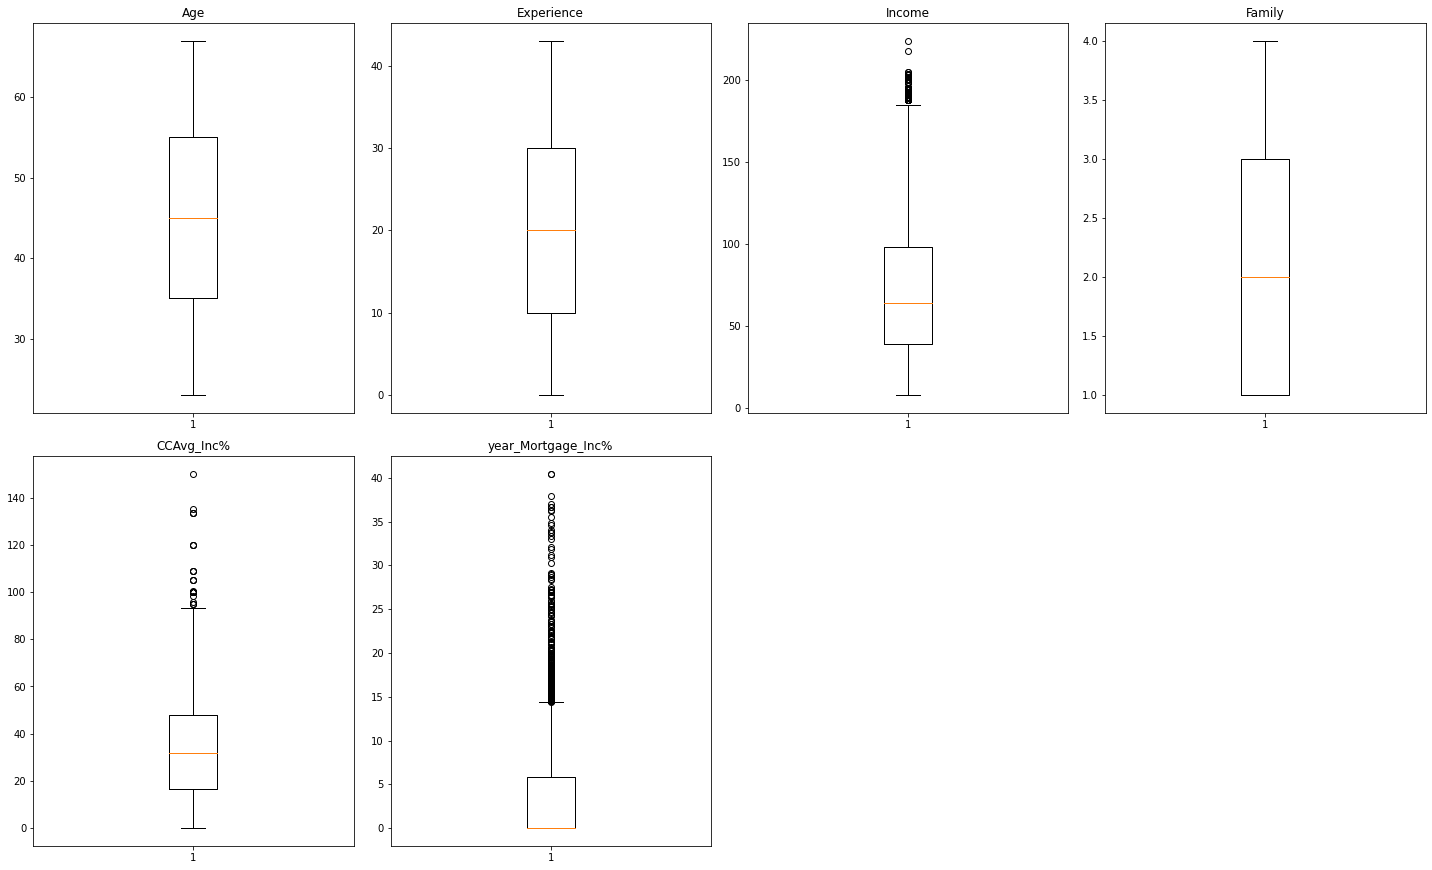

In [ ]:
numerical_col = ploancp_df.select_dtypes(include=np.number).columns.tolist()
plt.figure(figsize=(20, 30))

for i, variable in enumerate(numerical_col):
    plt.subplot(5, 4, i + 1)
    plt.boxplot(ploancp_df[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

In [ ]:
ploancp_df.dtypes

Age                     int64
Experience              int64
Income                  int64
ZIPCode                object
Family                  int64
Education              object
Personal_Loan          object
Securities_Account     object
CD_Account             object
Online                 object
CreditCard             object
CCAvg_Inc%            float64
year_Mortgage_Inc%    float64
dtype: object

# Logistic Regression

Should we hot-encode or dummy any features?
1. Personal Loan, Securities Account, CD_Account, Online, CreditCard are ok as they are since they are either a 1 for Yes, and 0 for No.

2. The big issue is ZIPCodes. Although there are over 400 zipcodes, how else could we introduce ZIPcodes? Will we be overfitting the model? Should we stick to dimension reduction by binning zip codes?

However, if we bin zip codes, like for example, regions or states, we may lose data.

We will aim to hot encode zip codes.

First, lets convert our Objects to integers 0 or 1 w/o considering ZIPCode for the time being.

In [ ]:
cols_num2cat = ['Education','Personal_Loan','Securities_Account','CD_Account','Online','CreditCard','CCAvg_Inc%','year_Mortgage_Inc%']  
ploancp_df[cols_num2cat] = ploancp_df[cols_num2cat].astype('int')

Lets take a look at the correlation between numerical features.

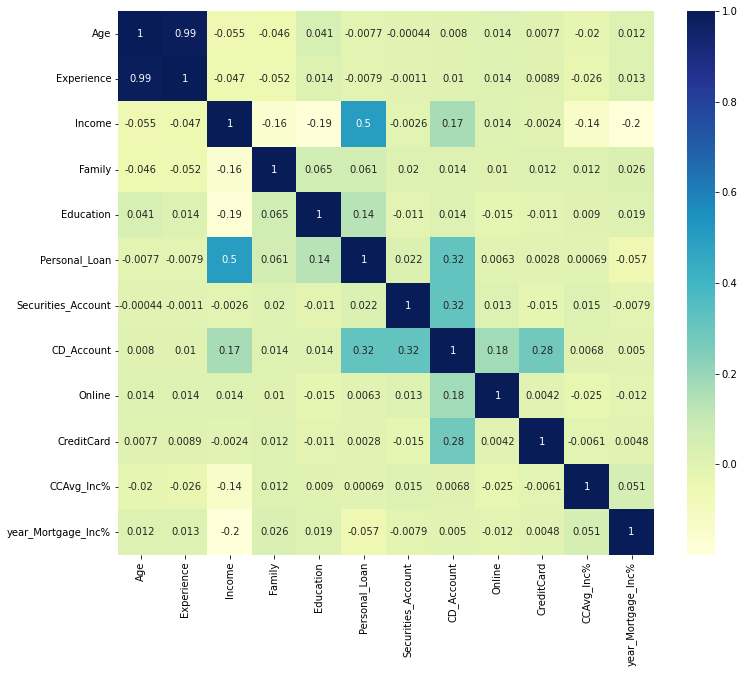

In [ ]:
fig, ax = plt.subplots(figsize=(12,10)) 
ax=sns.heatmap(ploancp_df.corr(), cmap="YlGnBu", annot=True)

Correlation Levels for Features vs Personal Loan
Medium Correlation :  Income and Personal Loan (0.5)
Medium Low Correlation: CD_Account and Personal Loan (0.32)
Low Correlation : Education and Personal Loan (0.14)

Now lets hot-encode (dummy) the ZIP Codes.

In [ ]:
ploancp_df= pd.get_dummies(ploancp_df, columns = ['ZIPCode'])

In [ ]:
ploancp_df.head()

,Age,Experience,Income,Family,Education,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,CCAvg_Inc%,year_Mortgage_Inc%,ZIPCode_90005,ZIPCode_90007,ZIPCode_90009,ZIPCode_90011,ZIPCode_90016,ZIPCode_90018,ZIPCode_90019,ZIPCode_90024,ZIPCode_90025,ZIPCode_90027,ZIPCode_90028,ZIPCode_90029,ZIPCode_90032,ZIPCode_90033,ZIPCode_90034,ZIPCode_90035,ZIPCode_90036,ZIPCode_90037,ZIPCode_90041,ZIPCode_90044,ZIPCode_90045,ZIPCode_90048,ZIPCode_90049,ZIPCode_90057,ZIPCode_90058,ZIPCode_90059,ZIPCode_90064,ZIPCode_90065,ZIPCode_90066,ZIPCode_90068,ZIPCode_90071,ZIPCode_90073,ZIPCode_90086,ZIPCode_90089,ZIPCode_90095,ZIPCode_90210,ZIPCode_90212,ZIPCode_90230,ZIPCode_90232,ZIPCode_90245,ZIPCode_90250,ZIPCode_90254,ZIPCode_90266,ZIPCode_90272,ZIPCode_90274,ZIPCode_90275,ZIPCode_90277,ZIPCode_90280,ZIPCode_90291,ZIPCode_90304,ZIPCode_90401,ZIPCode_90404,ZIPCode_90405,ZIPCode_90502,ZIPCode_90503,ZIPCode_90504,ZIPCode_90505,ZIPCode_90509,ZIPCode_90601,ZIPCode_90623,ZIPCode_90630,ZIPCode_90638,ZIPCode_90639,ZIPCode_90640,ZIPCode_90650,ZIPCode_90717,ZIPCode_90720,ZIPCode_90740,ZIPCode_90745,ZIPCode_90747,ZIPCode_90755,ZIPCode_90813,ZIPCode_90840,ZIPCode_91006,ZIPCode_91007,ZIPCode_91016,ZIPCode_91024,ZIPCode_91030,ZIPCode_91040,ZIPCode_91101,ZIPCode_91103,ZIPCode_91105,ZIPCode_91107,ZIPCode_91109,ZIPCode_91116,ZIPCode_91125,ZIPCode_91129,ZIPCode_91203,ZIPCode_91207,ZIPCode_91301,ZIPCode_91302,ZIPCode_91304,ZIPCode_91311,ZIPCode_91320,ZIPCode_91326,ZIPCode_91330,ZIPCode_91335,ZIPCode_91342,ZIPCode_91343,ZIPCode_91345,ZIPCode_91355,ZIPCode_91360,ZIPCode_91361,ZIPCode_91365,ZIPCode_91367,ZIPCode_91380,ZIPCode_91401,ZIPCode_91423,ZIPCode_91604,ZIPCode_91605,ZIPCode_91614,ZIPCode_91706,ZIPCode_91709,ZIPCode_91710,ZIPCode_91711,ZIPCode_91730,ZIPCode_91741,ZIPCode_91745,ZIPCode_91754,ZIPCode_91763,ZIPCode_91765,ZIPCode_91768,ZIPCode_91770,ZIPCode_91773,ZIPCode_91775,ZIPCode_91784,ZIPCode_91791,ZIPCode_91801,ZIPCode_91902,ZIPCode_91910,ZIPCode_91911,ZIPCode_91941,ZIPCode_91942,ZIPCode_91950,ZIPCode_92007,ZIPCode_92008,ZIPCode_92009,ZIPCode_92024,ZIPCode_92028,ZIPCode_92029,ZIPCode_92037,ZIPCode_92038,ZIPCode_92054,ZIPCode_92056,ZIPCode_92064,ZIPCode_92068,ZIPCode_92069,ZIPCode_92084,ZIPCode_92093,ZIPCode_92096,ZIPCode_92101,ZIPCode_92103,ZIPCode_92104,ZIPCode_92106,ZIPCode_92109,ZIPCode_92110,ZIPCode_92115,ZIPCode_92116,ZIPCode_92120,ZIPCode_92121,ZIPCode_92122,ZIPCode_92123,ZIPCode_92124,ZIPCode_92126,ZIPCode_92129,ZIPCode_92130,ZIPCode_92131,ZIPCode_92152,ZIPCode_92154,ZIPCode_92161,ZIPCode_92173,ZIPCode_92177,ZIPCode_92182,ZIPCode_92192,ZIPCode_92220,ZIPCode_92251,ZIPCode_92325,ZIPCode_92333,ZIPCode_92346,ZIPCode_92350,ZIPCode_92354,ZIPCode_92373,ZIPCode_92374,ZIPCode_92399,ZIPCode_92407,ZIPCode_92507,ZIPCode_92518,ZIPCode_92521,ZIPCode_92606,ZIPCode_92612,ZIPCode_92614,ZIPCode_92624,ZIPCode_92626,ZIPCode_92630,ZIPCode_92634,ZIPCode_92646,ZIPCode_92647,ZIPCode_92648,ZIPCode_92653,ZIPCode_92660,ZIPCode_92661,ZIPCode_92672,ZIPCode_92673,ZIPCode_92675,ZIPCode_92677,ZIPCode_92691,ZIPCode_92692,ZIPCode_92694,ZIPCode_92697,ZIPCode_92703,ZIPCode_92704,ZIPCode_92705,ZIPCode_92709,ZIPCode_92717,ZIPCode_92735,ZIPCode_92780,ZIPCode_92806,ZIPCode_92807,ZIPCode_92821,ZIPCode_92831,ZIPCode_92833,ZIPCode_92834,ZIPCode_92835,ZIPCode_92843,ZIPCode_92866,ZIPCode_92867,ZIPCode_92868,ZIPCode_92870,ZIPCode_92886,ZIPCode_93003,ZIPCode_93009,ZIPCode_93010,ZIPCode_93014,ZIPCode_93022,ZIPCode_93023,ZIPCode_93033,ZIPCode_93063,ZIPCode_93065,ZIPCode_93077,ZIPCode_93101,ZIPCode_93105,ZIPCode_93106,ZIPCode_93107,ZIPCode_93108,ZIPCode_93109,ZIPCode_93111,ZIPCode_93117,ZIPCode_93118,ZIPCode_93302,ZIPCode_93305,ZIPCode_93311,ZIPCode_93401,ZIPCode_93403,ZIPCode_93407,ZIPCode_93437,ZIPCode_93460,ZIPCode_93524,ZIPCode_93555,ZIPCode_93561,ZIPCode_93611,ZIPCode_93657,ZIPCode_93711,ZIPCode_93720,ZIPCode_93727,ZIPCode_93907,ZIPCode_93933,ZIPCode_93940,ZIPCode_93943,ZIPCode_93950,ZIPCode_93955,ZIPCode_94002,ZIPCode_94005,ZIPCode_94010,ZIPCode_94015,ZIPCode_94019,ZIPCode_94022,ZIPC

In [ ]:
ploancp_df.dtypes

Age              int64
Experience       int64
Income           int64
Family           int64
Education        int64
                 ...  
ZIPCode_96091    uint8
ZIPCode_96094    uint8
ZIPCode_96145    uint8
ZIPCode_96150    uint8
ZIPCode_96651    uint8
Length: 479, dtype: object

Lets drop the Target Feature (Personal Loan)

In [ ]:
X = ploancp_df.drop(["Personal_Loan"], axis=1)
Y = ploancp_df["Personal_Loan"]

X = pd.get_dummies(X, drop_first=True)

In [ ]:
X

,Age,Experience,Income,Family,Education,Securities_Account,CD_Account,Online,CreditCard,CCAvg_Inc%,year_Mortgage_Inc%,ZIPCode_90005,ZIPCode_90007,ZIPCode_90009,ZIPCode_90011,ZIPCode_90016,ZIPCode_90018,ZIPCode_90019,ZIPCode_90024,ZIPCode_90025,ZIPCode_90027,ZIPCode_90028,ZIPCode_90029,ZIPCode_90032,ZIPCode_90033,ZIPCode_90034,ZIPCode_90035,ZIPCode_90036,ZIPCode_90037,ZIPCode_90041,ZIPCode_90044,ZIPCode_90045,ZIPCode_90048,ZIPCode_90049,ZIPCode_90057,ZIPCode_90058,ZIPCode_90059,ZIPCode_90064,ZIPCode_90065,ZIPCode_90066,ZIPCode_90068,ZIPCode_90071,ZIPCode_90073,ZIPCode_90086,ZIPCode_90089,ZIPCode_90095,ZIPCode_90210,ZIPCode_90212,ZIPCode_90230,ZIPCode_90232,ZIPCode_90245,ZIPCode_90250,ZIPCode_90254,ZIPCode_90266,ZIPCode_90272,ZIPCode_90274,ZIPCode_90275,ZIPCode_90277,ZIPCode_90280,ZIPCode_90291,ZIPCode_90304,ZIPCode_90401,ZIPCode_90404,ZIPCode_90405,ZIPCode_90502,ZIPCode_90503,ZIPCode_90504,ZIPCode_90505,ZIPCode_90509,ZIPCode_90601,ZIPCode_90623,ZIPCode_90630,ZIPCode_90638,ZIPCode_90639,ZIPCode_90640,ZIPCode_90650,ZIPCode_90717,ZIPCode_90720,ZIPCode_90740,ZIPCode_90745,ZIPCode_90747,ZIPCode_90755,ZIPCode_90813,ZIPCode_90840,ZIPCode_91006,ZIPCode_91007,ZIPCode_91016,ZIPCode_91024,ZIPCode_91030,ZIPCode_91040,ZIPCode_91101,ZIPCode_91103,ZIPCode_91105,ZIPCode_91107,ZIPCode_91109,ZIPCode_91116,ZIPCode_91125,ZIPCode_91129,ZIPCode_91203,ZIPCode_91207,ZIPCode_91301,ZIPCode_91302,ZIPCode_91304,ZIPCode_91311,ZIPCode_91320,ZIPCode_91326,ZIPCode_91330,ZIPCode_91335,ZIPCode_91342,ZIPCode_91343,ZIPCode_91345,ZIPCode_91355,ZIPCode_91360,ZIPCode_91361,ZIPCode_91365,ZIPCode_91367,ZIPCode_91380,ZIPCode_91401,ZIPCode_91423,ZIPCode_91604,ZIPCode_91605,ZIPCode_91614,ZIPCode_91706,ZIPCode_91709,ZIPCode_91710,ZIPCode_91711,ZIPCode_91730,ZIPCode_91741,ZIPCode_91745,ZIPCode_91754,ZIPCode_91763,ZIPCode_91765,ZIPCode_91768,ZIPCode_91770,ZIPCode_91773,ZIPCode_91775,ZIPCode_91784,ZIPCode_91791,ZIPCode_91801,ZIPCode_91902,ZIPCode_91910,ZIPCode_91911,ZIPCode_91941,ZIPCode_91942,ZIPCode_91950,ZIPCode_92007,ZIPCode_92008,ZIPCode_92009,ZIPCode_92024,ZIPCode_92028,ZIPCode_92029,ZIPCode_92037,ZIPCode_92038,ZIPCode_92054,ZIPCode_92056,ZIPCode_92064,ZIPCode_92068,ZIPCode_92069,ZIPCode_92084,ZIPCode_92093,ZIPCode_92096,ZIPCode_92101,ZIPCode_92103,ZIPCode_92104,ZIPCode_92106,ZIPCode_92109,ZIPCode_92110,ZIPCode_92115,ZIPCode_92116,ZIPCode_92120,ZIPCode_92121,ZIPCode_92122,ZIPCode_92123,ZIPCode_92124,ZIPCode_92126,ZIPCode_92129,ZIPCode_92130,ZIPCode_92131,ZIPCode_92152,ZIPCode_92154,ZIPCode_92161,ZIPCode_92173,ZIPCode_92177,ZIPCode_92182,ZIPCode_92192,ZIPCode_92220,ZIPCode_92251,ZIPCode_92325,ZIPCode_92333,ZIPCode_92346,ZIPCode_92350,ZIPCode_92354,ZIPCode_92373,ZIPCode_92374,ZIPCode_92399,ZIPCode_92407,ZIPCode_92507,ZIPCode_92518,ZIPCode_92521,ZIPCode_92606,ZIPCode_92612,ZIPCode_92614,ZIPCode_92624,ZIPCode_92626,ZIPCode_92630,ZIPCode_92634,ZIPCode_92646,ZIPCode_92647,ZIPCode_92648,ZIPCode_92653,ZIPCode_92660,ZIPCode_92661,ZIPCode_92672,ZIPCode_92673,ZIPCode_92675,ZIPCode_92677,ZIPCode_92691,ZIPCode_92692,ZIPCode_92694,ZIPCode_92697,ZIPCode_92703,ZIPCode_92704,ZIPCode_92705,ZIPCode_92709,ZIPCode_92717,ZIPCode_92735,ZIPCode_92780,ZIPCode_92806,ZIPCode_92807,ZIPCode_92821,ZIPCode_92831,ZIPCode_92833,ZIPCode_92834,ZIPCode_92835,ZIPCode_92843,ZIPCode_92866,ZIPCode_92867,ZIPCode_92868,ZIPCode_92870,ZIPCode_92886,ZIPCode_93003,ZIPCode_93009,ZIPCode_93010,ZIPCode_93014,ZIPCode_93022,ZIPCode_93023,ZIPCode_93033,ZIPCode_93063,ZIPCode_93065,ZIPCode_93077,ZIPCode_93101,ZIPCode_93105,ZIPCode_93106,ZIPCode_93107,ZIPCode_93108,ZIPCode_93109,ZIPCode_93111,ZIPCode_93117,ZIPCode_93118,ZIPCode_93302,ZIPCode_93305,ZIPCode_93311,ZIPCode_93401,ZIPCode_93403,ZIPCode_93407,ZIPCode_93437,ZIPCode_93460,ZIPCode_93524,ZIPCode_93555,ZIPCode_93561,ZIPCode_93611,ZIPCode_93657,ZIPCode_93711,ZIPCode_93720,ZIPCode_93727,ZIPCode_93907,ZIPCode_93933,ZIPCode_93940,ZIPCode_93943,ZIPCode_93950,ZIPCode_93955,ZIPCode_94002,ZIPCode_94005,ZIPCode_94010,ZIPCode_94015,ZIPCode_94019,ZIPCode_94022,ZIPCode_94024,ZIPC

Split Train and Test Sets 70-30

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.30, random_state=1
)

In [ ]:
print("Shape of Training set : ", X_train.shape)
print("Shape of test set : ", X_test.shape)
print("Percentage of classes in training set:")
print(y_train.value_counts(normalize=True))
print("Percentage of classes in test set:")
print(y_test.value_counts(normalize=True))

Shape of Training set :  (3500, 478)
Shape of test set :  (1500, 478)
Percentage of classes in training set:
0   0.905
1   0.095
Name: Personal_Loan, dtype: float64
Percentage of classes in test set:
0   0.901
1   0.099
Name: Personal_Loan, dtype: float64


In [ ]:
X_train

,Age,Experience,Income,Family,Education,Securities_Account,CD_Account,Online,CreditCard,CCAvg_Inc%,year_Mortgage_Inc%,ZIPCode_90005,ZIPCode_90007,ZIPCode_90009,ZIPCode_90011,ZIPCode_90016,ZIPCode_90018,ZIPCode_90019,ZIPCode_90024,ZIPCode_90025,ZIPCode_90027,ZIPCode_90028,ZIPCode_90029,ZIPCode_90032,ZIPCode_90033,ZIPCode_90034,ZIPCode_90035,ZIPCode_90036,ZIPCode_90037,ZIPCode_90041,ZIPCode_90044,ZIPCode_90045,ZIPCode_90048,ZIPCode_90049,ZIPCode_90057,ZIPCode_90058,ZIPCode_90059,ZIPCode_90064,ZIPCode_90065,ZIPCode_90066,ZIPCode_90068,ZIPCode_90071,ZIPCode_90073,ZIPCode_90086,ZIPCode_90089,ZIPCode_90095,ZIPCode_90210,ZIPCode_90212,ZIPCode_90230,ZIPCode_90232,ZIPCode_90245,ZIPCode_90250,ZIPCode_90254,ZIPCode_90266,ZIPCode_90272,ZIPCode_90274,ZIPCode_90275,ZIPCode_90277,ZIPCode_90280,ZIPCode_90291,ZIPCode_90304,ZIPCode_90401,ZIPCode_90404,ZIPCode_90405,ZIPCode_90502,ZIPCode_90503,ZIPCode_90504,ZIPCode_90505,ZIPCode_90509,ZIPCode_90601,ZIPCode_90623,ZIPCode_90630,ZIPCode_90638,ZIPCode_90639,ZIPCode_90640,ZIPCode_90650,ZIPCode_90717,ZIPCode_90720,ZIPCode_90740,ZIPCode_90745,ZIPCode_90747,ZIPCode_90755,ZIPCode_90813,ZIPCode_90840,ZIPCode_91006,ZIPCode_91007,ZIPCode_91016,ZIPCode_91024,ZIPCode_91030,ZIPCode_91040,ZIPCode_91101,ZIPCode_91103,ZIPCode_91105,ZIPCode_91107,ZIPCode_91109,ZIPCode_91116,ZIPCode_91125,ZIPCode_91129,ZIPCode_91203,ZIPCode_91207,ZIPCode_91301,ZIPCode_91302,ZIPCode_91304,ZIPCode_91311,ZIPCode_91320,ZIPCode_91326,ZIPCode_91330,ZIPCode_91335,ZIPCode_91342,ZIPCode_91343,ZIPCode_91345,ZIPCode_91355,ZIPCode_91360,ZIPCode_91361,ZIPCode_91365,ZIPCode_91367,ZIPCode_91380,ZIPCode_91401,ZIPCode_91423,ZIPCode_91604,ZIPCode_91605,ZIPCode_91614,ZIPCode_91706,ZIPCode_91709,ZIPCode_91710,ZIPCode_91711,ZIPCode_91730,ZIPCode_91741,ZIPCode_91745,ZIPCode_91754,ZIPCode_91763,ZIPCode_91765,ZIPCode_91768,ZIPCode_91770,ZIPCode_91773,ZIPCode_91775,ZIPCode_91784,ZIPCode_91791,ZIPCode_91801,ZIPCode_91902,ZIPCode_91910,ZIPCode_91911,ZIPCode_91941,ZIPCode_91942,ZIPCode_91950,ZIPCode_92007,ZIPCode_92008,ZIPCode_92009,ZIPCode_92024,ZIPCode_92028,ZIPCode_92029,ZIPCode_92037,ZIPCode_92038,ZIPCode_92054,ZIPCode_92056,ZIPCode_92064,ZIPCode_92068,ZIPCode_92069,ZIPCode_92084,ZIPCode_92093,ZIPCode_92096,ZIPCode_92101,ZIPCode_92103,ZIPCode_92104,ZIPCode_92106,ZIPCode_92109,ZIPCode_92110,ZIPCode_92115,ZIPCode_92116,ZIPCode_92120,ZIPCode_92121,ZIPCode_92122,ZIPCode_92123,ZIPCode_92124,ZIPCode_92126,ZIPCode_92129,ZIPCode_92130,ZIPCode_92131,ZIPCode_92152,ZIPCode_92154,ZIPCode_92161,ZIPCode_92173,ZIPCode_92177,ZIPCode_92182,ZIPCode_92192,ZIPCode_92220,ZIPCode_92251,ZIPCode_92325,ZIPCode_92333,ZIPCode_92346,ZIPCode_92350,ZIPCode_92354,ZIPCode_92373,ZIPCode_92374,ZIPCode_92399,ZIPCode_92407,ZIPCode_92507,ZIPCode_92518,ZIPCode_92521,ZIPCode_92606,ZIPCode_92612,ZIPCode_92614,ZIPCode_92624,ZIPCode_92626,ZIPCode_92630,ZIPCode_92634,ZIPCode_92646,ZIPCode_92647,ZIPCode_92648,ZIPCode_92653,ZIPCode_92660,ZIPCode_92661,ZIPCode_92672,ZIPCode_92673,ZIPCode_92675,ZIPCode_92677,ZIPCode_92691,ZIPCode_92692,ZIPCode_92694,ZIPCode_92697,ZIPCode_92703,ZIPCode_92704,ZIPCode_92705,ZIPCode_92709,ZIPCode_92717,ZIPCode_92735,ZIPCode_92780,ZIPCode_92806,ZIPCode_92807,ZIPCode_92821,ZIPCode_92831,ZIPCode_92833,ZIPCode_92834,ZIPCode_92835,ZIPCode_92843,ZIPCode_92866,ZIPCode_92867,ZIPCode_92868,ZIPCode_92870,ZIPCode_92886,ZIPCode_93003,ZIPCode_93009,ZIPCode_93010,ZIPCode_93014,ZIPCode_93022,ZIPCode_93023,ZIPCode_93033,ZIPCode_93063,ZIPCode_93065,ZIPCode_93077,ZIPCode_93101,ZIPCode_93105,ZIPCode_93106,ZIPCode_93107,ZIPCode_93108,ZIPCode_93109,ZIPCode_93111,ZIPCode_93117,ZIPCode_93118,ZIPCode_93302,ZIPCode_93305,ZIPCode_93311,ZIPCode_93401,ZIPCode_93403,ZIPCode_93407,ZIPCode_93437,ZIPCode_93460,ZIPCode_93524,ZIPCode_93555,ZIPCode_93561,ZIPCode_93611,ZIPCode_93657,ZIPCode_93711,ZIPCode_93720,ZIPCode_93727,ZIPCode_93907,ZIPCode_93933,ZIPCode_93940,ZIPCode_93943,ZIPCode_93950,ZIPCode_93955,ZIPCode_94002,ZIPCode_94005,ZIPCode_94010,ZIPCode_94015,ZIPCode_94019,ZIPCode_94022,ZIPCode_94024,ZIPC

In [ ]:
y_train

1334    0
4768    0
65      0
177     0
4489    0
       ..
2895    0
2763    0
905     0
3980    0
235     0
Name: Personal_Loan, Length: 3500, dtype: int64

In [ ]:
y_test

2764    0
4767    0
3814    0
3499    0
2735    0
       ..
4140    0
3969    0
2535    0
1361    0
1458    0
Name: Personal_Loan, Length: 1500, dtype: int64

In [ ]:
# There are different solvers available in Sklearn logistic regression
# The newton-cg solver is faster for high-dimensional data
lg = LogisticRegression(solver="newton-cg", random_state=1)
model = lg.fit(X_train, y_train)

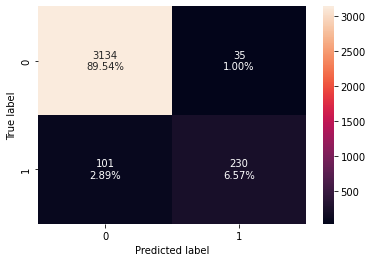

In [ ]:
# creating confusion matrix for training sets
confusion_matrix_sklearn_with_threshold(lg, X_train, y_train)

From the Confusion Matrix for the Training sets we determine that the LogisticRegression model resulted in TP=290 (6.57%), TN = 3134 (89.54%), and FP=35 (1%), FN=101 (2.89%).


In [ ]:
log_reg_model_train_perf = model_performance_classification_sklearn_with_threshold(
    lg, X_train, y_train
)

print("Training performance:")
log_reg_model_train_perf

Training performance:


,Accuracy,Recall,Precision,F1
0,0.961,0.695,0.868,0.772


The model is already at 0.953 accuracy for Training.

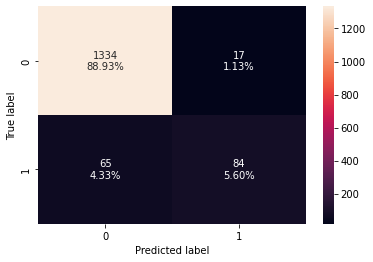

In [ ]:
# creating confusion matrix for testing sets
confusion_matrix_sklearn_with_threshold(lg, X_test, y_test)

From the Confusion Matrix for the Testing sets we determine that the LogisticRegression model resulted in TP=84 (5.60%), TN = 1334 (88.93%), and FP=17 (1.13%), FN=65 (4.33%).

In [ ]:
log_reg_model_test_perf = model_performance_classification_sklearn_with_threshold(
    lg, X_test, y_test
)

print("Test set performance:")
log_reg_model_test_perf

Test set performance:


,Accuracy,Recall,Precision,F1
0,0.945,0.564,0.832,0.672


Accuracy for the Testing Set is at 0.949, sligtly less than for the Training set.

ROC-AUC
The area under the ROC curve (AUC) is a measure of how good a model is - The higher the AUC, the better the model is, at distinguishing between classes.
1. predict_proba
Predicts the probabilities for the class 0 and 1.

Input: Train or test data

Output: Returns the predicted probabilities for class 0 and 1

2. roc_curve_score
Returns the auc scores

Input: 1. Training data 2. Predicted Probability

Output: AUC scores between 0 and 1

3. roc_curve
Returns the fpr, tpr and threshold values which takes the original data and predicted probabilities for the class 1.

Input: 1. Training data 2. Predicted Probability

Output: False positive rate, true positive rate and threshold values

ROC-AUC on training set

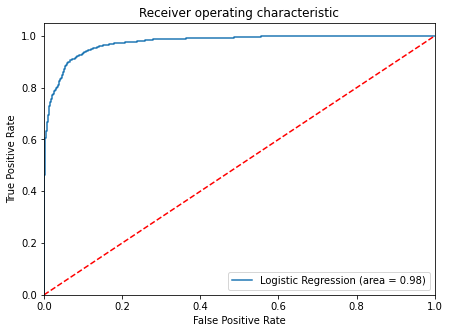

In [ ]:
# Find the roc auc score for training data
logit_roc_auc_train = roc_auc_score(
    y_train, lg.predict_proba(X_train)[:, 1]
)  # The indexing represents predicted probabilities for class 1
# Find fpr, tpr and threshold values
fpr, tpr, thresholds = roc_curve(y_train, lg.predict_proba(X_train)[:, 1])
plt.figure(figsize=(7, 5))
# Plot roc curve
plt.plot(fpr, tpr, label="Logistic Regression (area = %0.2f)" % logit_roc_auc_train)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

ROC-AUC on test set

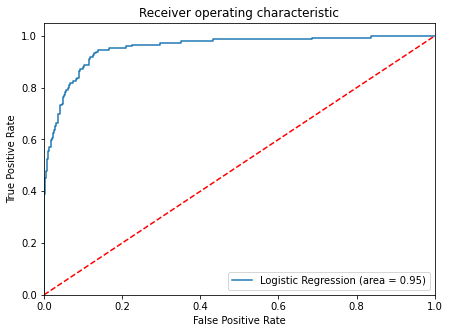

In [ ]:
# Find the roc auc score for testing data
logit_roc_auc_test = roc_auc_score(
    y_test, lg.predict_proba(X_test)[:, 1]
)  # The indexing represents predicted probabilities for class 1
# Find fpr, tpr and threshold values
fpr, tpr, thresholds = roc_curve(y_test, lg.predict_proba(X_test)[:, 1])
plt.figure(figsize=(7, 5))
# Plot roc curve
plt.plot(fpr, tpr, label="Logistic Regression (area = %0.2f)" % logit_roc_auc_test)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

Model is giving a generalized performance.

# Model Performance Improvement

Let's see if the f1 score can be improved further, by changing the model threshold using AUC-ROC Curve.

Optimal threshold using AUC-ROC curve

Optimal thresold is the value that best separated the True positive rate and False positive rate.

In [ ]:
# Optimal threshold as per AUC-ROC curve
# The optimal cut off would be where tpr is high and fpr is low
# roc_curve returns the fpr, tpr and threshold values which takes the original data and predicted probabilities for the class 1.
fpr, tpr, thresholds = roc_curve(
    y_train, lg.predict_proba(X_train)[:, 1]
)  # The indexing represents predicted probabilities for class 1

optimal_idx = np.argmax(
    tpr - fpr
)  # Finds the index that contains the max difference between tpr and fpr
optimal_threshold_auc_roc = thresholds[
    optimal_idx
]  # stores the optimal threshold value
print(optimal_threshold_auc_roc)

0.1462257074057079


Checking model performance on training set

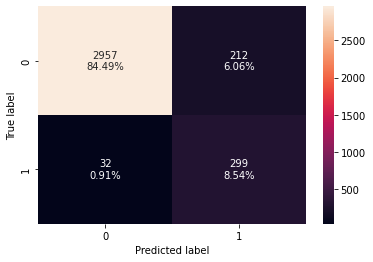

In [ ]:
# creating confusion matrix
confusion_matrix_sklearn_with_threshold(
    lg, X_train, y_train, threshold=optimal_threshold_auc_roc
)

From the Confusion Matrix for the Training sets we determine that the LogisticRegression model resulted in TP=299 (8.54%), TN = 2957 (84.49%), and FP=299 (8.54%), FN=32 (0.91%).

In [ ]:
# checking model performance for this model
log_reg_model_train_perf_threshold_auc_roc = model_performance_classification_sklearn_with_threshold(
    lg, X_train, y_train, threshold=optimal_threshold_auc_roc
)
print("Training performance:")
log_reg_model_train_perf_threshold_auc_roc

Training performance:


,Accuracy,Recall,Precision,F1
0,0.930,0.903,0.585,0.710


Notice that the accuracy is 0.930 on the training set.

Checking model performance on test set

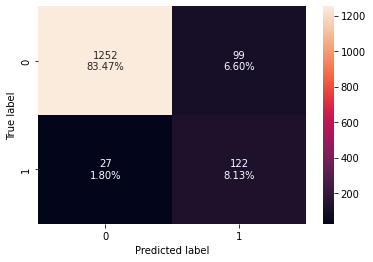

In [ ]:
# creating confusion matrix on test set
confusion_matrix_sklearn_with_threshold(
    lg, X_test, y_test, threshold=optimal_threshold_auc_roc
)

From the Confusion Matrix for the Testing sets we determine that the LogisticRegression model resulted in TP=122 (8.13%), TN = 1352 (83.47%), and FP=99 (6.60%), FN=27 (1.80%).

In [ ]:
# checking model performance for this model
log_reg_model_test_perf_threshold_auc_roc = model_performance_classification_sklearn_with_threshold(
    lg, X_test, y_test, threshold=optimal_threshold_auc_roc
)
print("Test set performance:")
log_reg_model_test_perf_threshold_auc_roc

Test set performance:


,Accuracy,Recall,Precision,F1
0,0.916,0.819,0.552,0.659


The precision of the model for both training and test set has improved but the F1 score has reduced.

Let's use Precision-Recall curve and see if we can find a better threshold

The Precision-Recall curve shows the tradeoff between Precision and Recall for different thresholds. It can be used to select optimal threshold as required to improve the model improvement.

precision_recall_curve()

Returns the fpr, tpr and threshold values

Input: 1. Original data 2. Predicted Probability

Output: False positive rate, true positive rate and threshold values

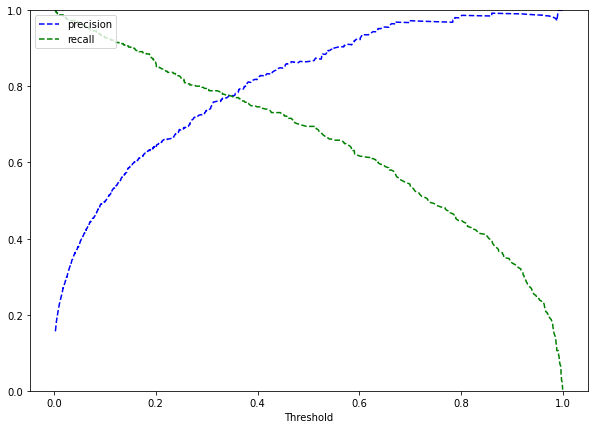

In [ ]:
# Find the predicted probabilities for class 1
y_scores = lg.predict_proba(X_train)[:, 1]
# Find fpr, tpr and threshold values
prec, rec, tre = precision_recall_curve(y_train, y_scores,)


def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])


plt.figure(figsize=(10, 7))
# Plot recall precision curve
plot_prec_recall_vs_tresh(prec, rec, tre)
plt.show()

At the threshold of 0.36, we get balanced recall and precision.

In [ ]:
# setting the threshold
optimal_threshold_curve = 0.37

Checking model performance on training set

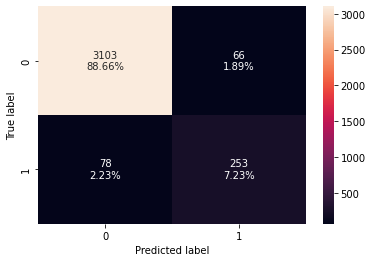

In [ ]:
# creating confusion matrix
confusion_matrix_sklearn_with_threshold(
    lg, X_train, y_train, threshold=optimal_threshold_curve
)

From the Confusion Matrix for the Training sets we determine that the LogisticRegression model resulted in TP=253 (25.3%), TN = 3103 (88.66%), and FP=66 (1.89%), FN=78 (2.23%).

In [ ]:
log_reg_model_train_perf_threshold_curve = model_performance_classification_sklearn_with_threshold(
    lg, X_train, y_train, threshold=optimal_threshold_curve
)
print("Training performance:")
log_reg_model_train_perf_threshold_curve

Training performance:


,Accuracy,Recall,Precision,F1
0,0.959,0.764,0.793,0.778


Checking model performance on test set

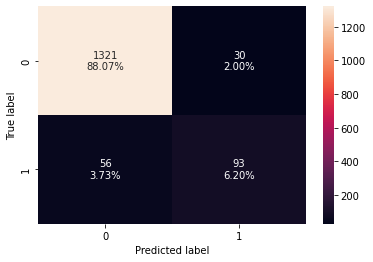

In [ ]:
# creating confusion matrix
confusion_matrix_sklearn_with_threshold(
    lg, X_test, y_test, threshold=optimal_threshold_curve
)

From the Confusion Matrix for the Training sets we determine that the LogisticRegression model resulted in TP=93 (6.20%), TN = 1321 (88.07%), and FP=30 (2%), FN=56 (3.73%).

In [1]:
log_reg_model_test_perf_threshold_curve = model_performance_classification_sklearn_with_threshold(
    lg, X_test, y_test, threshold=optimal_threshold_curve
)
print("Test set performance:")
log_reg_model_test_perf_threshold_curve

NameError: ignored

Model is performing well on training and test.
There's not much improvement in the model performance as the default threshold is 0.50 and here we get 0.37 as the optimal threshold.

Model Performance Summary

In [ ]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        log_reg_model_train_perf.T,
        log_reg_model_train_perf_threshold_auc_roc.T,
        log_reg_model_train_perf_threshold_curve.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Logistic Regression sklearn",
    "Logistic Regression-0.15 Threshold",
    "Logistic Regression-0.37 Threshold",
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Logistic Regression sklearn,Logistic Regression-0.15 Threshold,Logistic Regression-0.37 Threshold
Accuracy,0.961,0.930,0.959
Recall,0.695,0.903,0.764
Precision,0.868,0.585,0.793
F1,0.772,0.710,0.778


In [ ]:
# testing performance comparison

models_test_comp_df = pd.concat(
    [
        log_reg_model_test_perf.T,
        log_reg_model_test_perf_threshold_auc_roc.T,
        log_reg_model_test_perf_threshold_curve.T,
    ],
    axis=1,
)
models_test_comp_df.columns = [
    "Logistic Regression sklearn",
    "Logistic Regression-0.15 Threshold",
    "Logistic Regression-0.37 Threshold",
]
print("Test set performance comparison:")
models_test_comp_df

Test set performance comparison:


,Logistic Regression sklearn,Logistic Regression-0.15 Threshold,Logistic Regression-0.37 Threshold
Accuracy,0.945,0.916,0.943
Recall,0.564,0.819,0.624
Precision,0.832,0.552,0.756
F1,0.672,0.659,0.684


We can use the Logistic Regression-0.37 Threshold which yields the highest F1 score and a slightly smaller accuracy than the Logistic Regression sklearn model.

Logistic Regression-0.15 Threshold yields the largest Recall but Recall isn't a good metric for this case because the data is not balance (between Personal Loans yes and persona Loans No).

Logistic Regression-0.37 Threshold gives F1 0.68 and this is the mode we recommend if using Logistic Regression.

# Decision Tree

Use 'gini' criteria to split

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import sklearn.metrics as metrics

In [ ]:
dTree = DecisionTreeClassifier(criterion = 'gini', random_state=1)
dTree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

### Scoring the Decision Tree

In [ ]:
#scoring 
print("Accuracy on training set : ",dTree.score(X_train, y_train))
print("Accuracy on test set : ",dTree.score(X_test, y_test))

Accuracy on training set :  1.0
Accuracy on test set :  0.9746666666666667


Recall should be the metric of the model because Recall gives the ratio of True positives to Actual positives, which means liability customers that actually purchase a Personal Loan product.

In [ ]:
## Function to create confusion matrix
def make_confusion_matrix(model,y_actual,labels=[1, 0]):
    '''
    model : classifier to predict values of X
    y_actual : ground truth  
    
    '''
    y_predict = model.predict(X_test)
    cm=metrics.confusion_matrix( y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
##  Function to calculate recall score
def get_recall_score(model):
    '''
    model : classifier to predict values of X

    '''
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print("Recall on training set : ",metrics.recall_score(y_train,pred_train))
    print("Recall on test set : ",metrics.recall_score(y_test,pred_test))

### Confusion Matrix

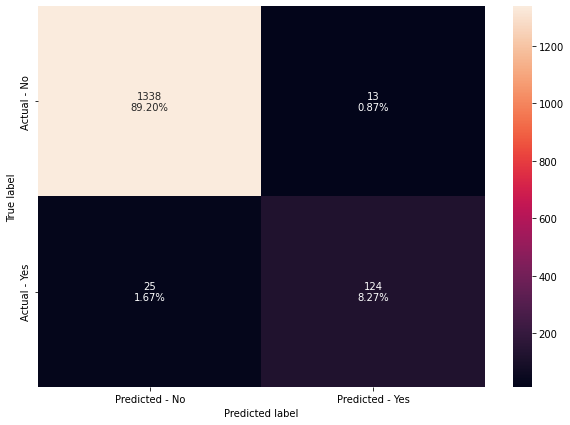

In [ ]:
make_confusion_matrix(dTree,y_test)

In [ ]:
# Recall on train and test
get_recall_score(dTree)

Recall on training set :  1.0
Recall on test set :  0.8322147651006712


### Visualization of Decision Tree

In [ ]:
feature_names = list(X.columns)
print(feature_names)

['Age', 'Experience', 'Income', 'Family', 'Education', 'Securities_Account', 'CD_Account', 'Online', 'CreditCard', 'CCAvg_Inc%', 'year_Mortgage_Inc%', 'ZIPCode_90005', 'ZIPCode_90007', 'ZIPCode_90009', 'ZIPCode_90011', 'ZIPCode_90016', 'ZIPCode_90018', 'ZIPCode_90019', 'ZIPCode_90024', 'ZIPCode_90025', 'ZIPCode_90027', 'ZIPCode_90028', 'ZIPCode_90029', 'ZIPCode_90032', 'ZIPCode_90033', 'ZIPCode_90034', 'ZIPCode_90035', 'ZIPCode_90036', 'ZIPCode_90037', 'ZIPCode_90041', 'ZIPCode_90044', 'ZIPCode_90045', 'ZIPCode_90048', 'ZIPCode_90049', 'ZIPCode_90057', 'ZIPCode_90058', 'ZIPCode_90059', 'ZIPCode_90064', 'ZIPCode_90065', 'ZIPCode_90066', 'ZIPCode_90068', 'ZIPCode_90071', 'ZIPCode_90073', 'ZIPCode_90086', 'ZIPCode_90089', 'ZIPCode_90095', 'ZIPCode_90210', 'ZIPCode_90212', 'ZIPCode_90230', 'ZIPCode_90232', 'ZIPCode_90245', 'ZIPCode_90250', 'ZIPCode_90254', 'ZIPCode_90266', 'ZIPCode_90272', 'ZIPCode_90274', 'ZIPCode_90275', 'ZIPCode_90277', 'ZIPCode_90280', 'ZIPCode_90291', 'ZIPCode_90304',

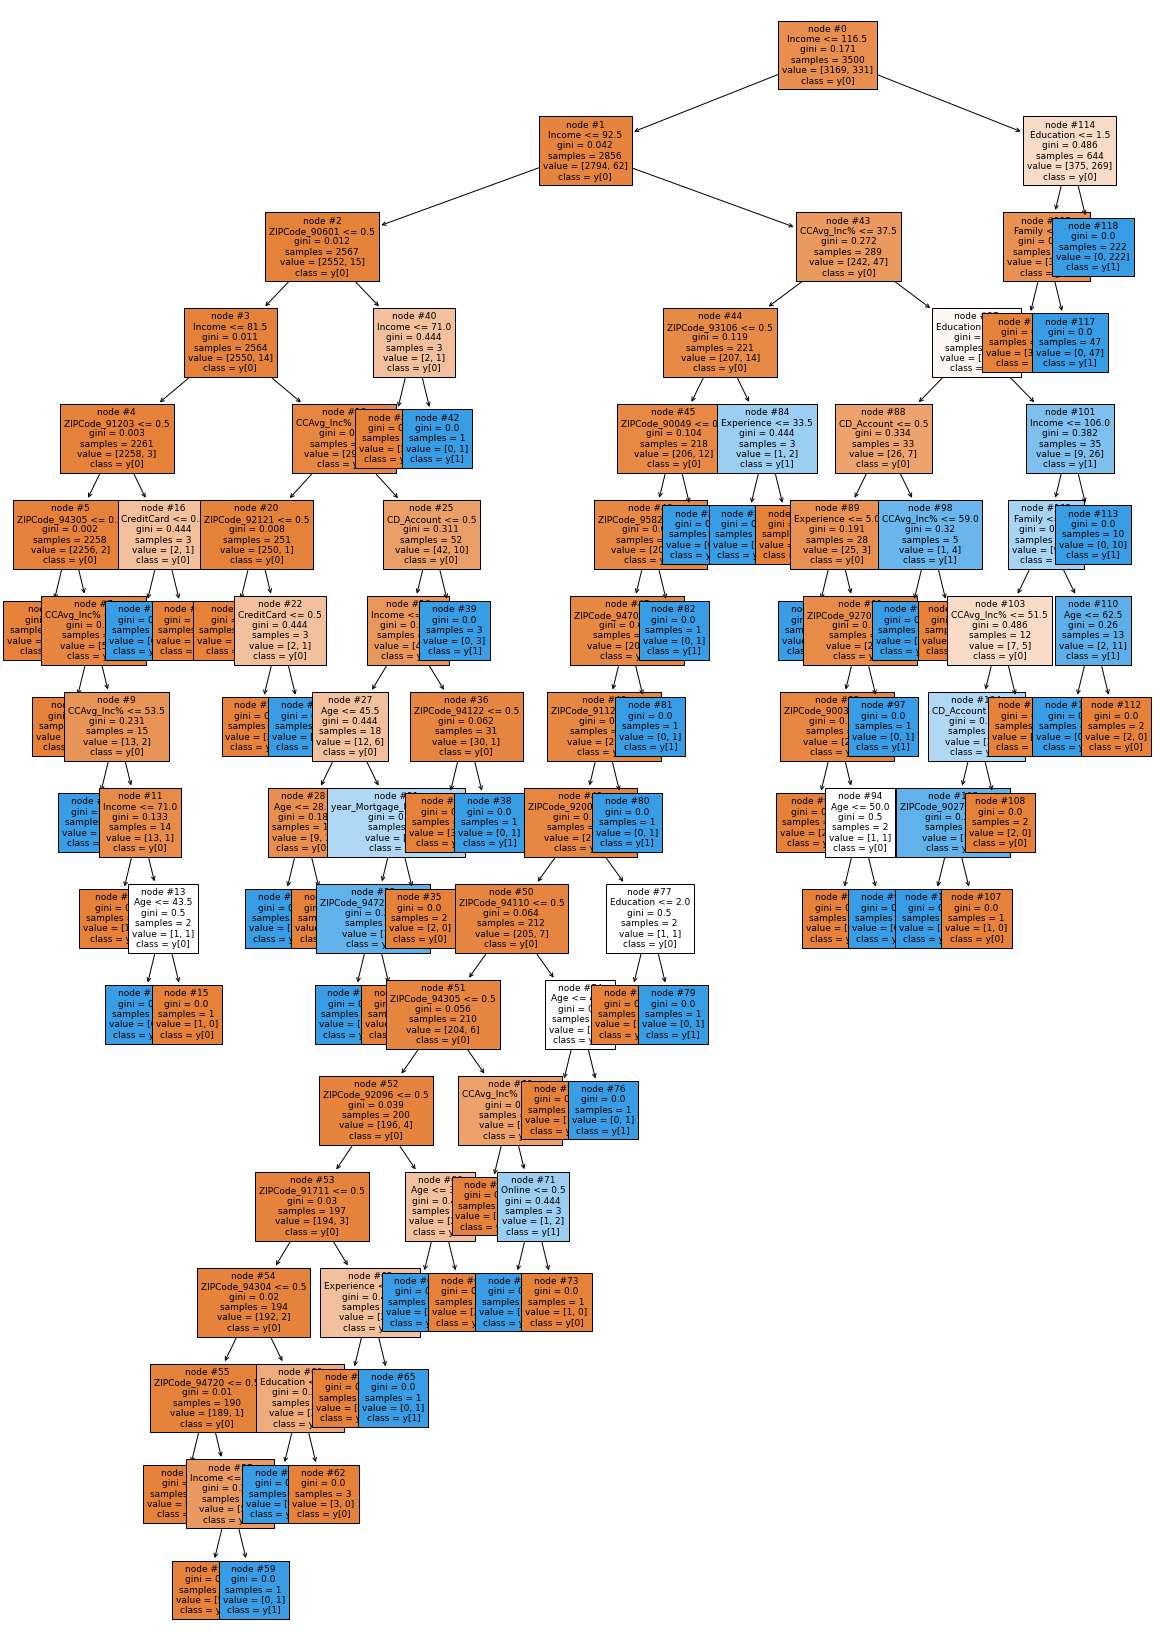

In [ ]:
plt.figure(figsize=(20,30))
tree.plot_tree(dTree,feature_names=feature_names,filled=True,fontsize=9,node_ids=True,class_names=True)
plt.show()

In [ ]:
# Text report showing the rules of a decision tree -

print(tree.export_text(dTree,feature_names=feature_names,show_weights=True))

|--- Income <= 116.50
|   |--- Income <= 92.50
|   |   |--- ZIPCode_90601 <= 0.50
|   |   |   |--- Income <= 81.50
|   |   |   |   |--- ZIPCode_91203 <= 0.50
|   |   |   |   |   |--- ZIPCode_94305 <= 0.50
|   |   |   |   |   |   |--- weights: [2198.00, 0.00] class: 0
|   |   |   |   |   |--- ZIPCode_94305 >  0.50
|   |   |   |   |   |   |--- CCAvg_Inc% <= 52.50
|   |   |   |   |   |   |   |--- weights: [45.00, 0.00] class: 0
|   |   |   |   |   |   |--- CCAvg_Inc% >  52.50
|   |   |   |   |   |   |   |--- CCAvg_Inc% <= 53.50
|   |   |   |   |   |   |   |   |--- weights: [0.00, 1.00] class: 1
|   |   |   |   |   |   |   |--- CCAvg_Inc% >  53.50
|   |   |   |   |   |   |   |   |--- Income <= 71.00
|   |   |   |   |   |   |   |   |   |--- weights: [12.00, 0.00] class: 0
|   |   |   |   |   |   |   |   |--- Income >  71.00
|   |   |   |   |   |   |   |   |   |--- Age <= 43.50
|   |   |   |   |   |   |   |   |   |   |--- weights: [0.00, 1.00] class: 1
|   |   |   |   |   |   |   |   |   |--

In [ ]:
# importance of features in the tree building ( The importance of a feature is computed as the 
#(normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance )

print (pd.DataFrame(dTree.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values(by = 'Imp', ascending = False))

                Imp
Education     0.403
Income        0.310
Family        0.143
CCAvg_Inc%    0.049
Age           0.020
...             ...
ZIPCode_92110 0.000
ZIPCode_92109 0.000
ZIPCode_92106 0.000
ZIPCode_92104 0.000
ZIPCode_96651 0.000

[478 rows x 1 columns]


According to the decision tree model, Education is the most important variable for predicting if the liaility customer will purchase a Personal Loan product. Notice that from our previous analysis, we determined that Income was the most important feature.

The tree above is very complex, such a tree often overfits. So lets reduce dimensions.

### Reducing Over Fitting

In [ ]:
dTree1 = DecisionTreeClassifier(criterion = 'gini',max_depth=3,random_state=1)
dTree1.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=1)

### Confusion Matrix - decision tree with depth restricted to 3

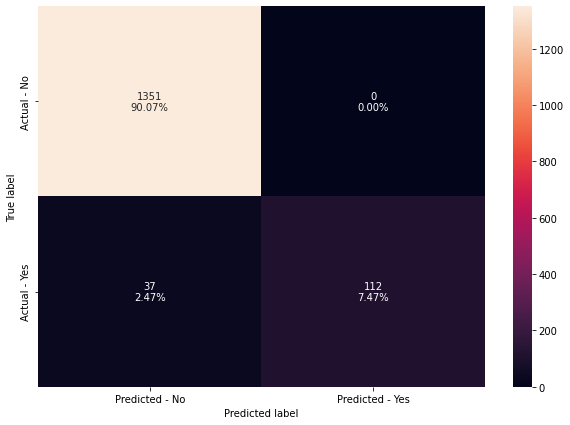

In [ ]:
make_confusion_matrix(dTree1, y_test)

In [ ]:
# Accuracy on train and test
print("Accuracy on training set : ",dTree1.score(X_train, y_train))
print("Accuracy on test set : ",dTree1.score(X_test, y_test))
# Recall on train and test
get_recall_score(dTree1)

Accuracy on training set :  0.9822857142857143
Accuracy on test set :  0.9753333333333334
Recall on training set :  0.8126888217522659
Recall on test set :  0.7516778523489933


Recall on Training has reduced from 1 to 0.81 which is better because the model overfitting has been reduced.

### Visualization of Decision Tree

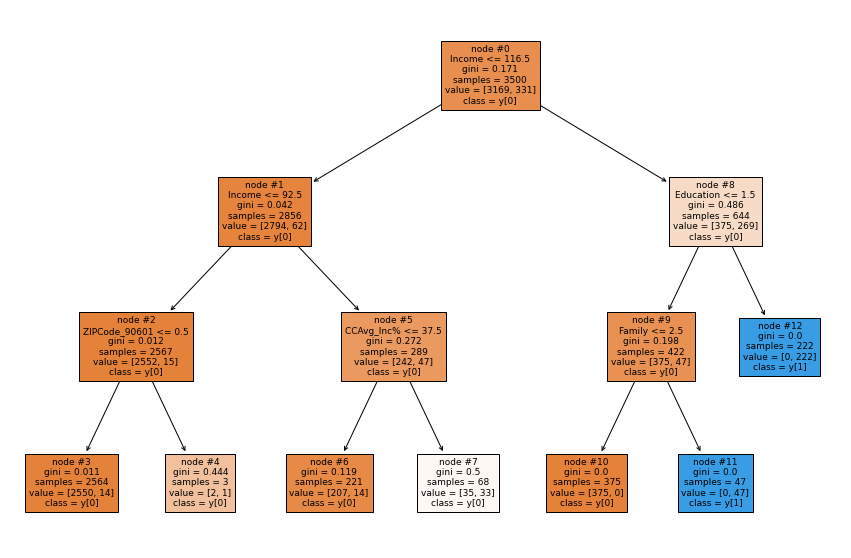

In [ ]:
plt.figure(figsize=(15,10))

tree.plot_tree(dTree1,feature_names=feature_names,filled=True,fontsize=9,node_ids=True,class_names=True)
plt.show()

In [ ]:
# Text report showing the rules of a decision tree -

print(tree.export_text(dTree1,feature_names=feature_names,show_weights=True))

|--- Income <= 116.50
|   |--- Income <= 92.50
|   |   |--- ZIPCode_90601 <= 0.50
|   |   |   |--- weights: [2550.00, 14.00] class: 0
|   |   |--- ZIPCode_90601 >  0.50
|   |   |   |--- weights: [2.00, 1.00] class: 0
|   |--- Income >  92.50
|   |   |--- CCAvg_Inc% <= 37.50
|   |   |   |--- weights: [207.00, 14.00] class: 0
|   |   |--- CCAvg_Inc% >  37.50
|   |   |   |--- weights: [35.00, 33.00] class: 0
|--- Income >  116.50
|   |--- Education <= 1.50
|   |   |--- Family <= 2.50
|   |   |   |--- weights: [375.00, 0.00] class: 0
|   |   |--- Family >  2.50
|   |   |   |--- weights: [0.00, 47.00] class: 1
|   |--- Education >  1.50
|   |   |--- weights: [0.00, 222.00] class: 1



The tree has become readable and the recall on the test set has reduced from 0.83 to 0.75

In [ ]:
# importance of features in the tree building ( The importance of a feature is computed as the 
#(normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance )

print (pd.DataFrame(dTree1.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values(by = 'Imp', ascending = False))

                Imp
Education     0.450
Income        0.348
Family        0.164
CCAvg_Inc%    0.036
ZIPCode_90601 0.001
...             ...
ZIPCode_92093 0.000
ZIPCode_92084 0.000
ZIPCode_92069 0.000
ZIPCode_92068 0.000
ZIPCode_96651 0.000

[478 rows x 1 columns]


With a depth of 3, the model is undefitting. So we are going to find the best values.

### Using GridSearch for Hyperparameter tuning of our tree model

Notes:
Hyperparameter tuning is also tricky in the sense that there is no direct way to calculate how a change in the hyperparameter value will reduce the loss of your model, so we usually resort to experimentation. i.e we'll use Grid search
Grid search is a tuning technique that attempts to compute the optimum values of hyperparameters.
It is an exhaustive search that is performed on a the specific parameter values of a model.
The parameters of the estimator/model used to apply these methods are optimized by cross-validated grid-searc

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# Choose the type of classifier. 
estimator = DecisionTreeClassifier(random_state=1)

# Grid of parameters to choose from
## add from article
parameters = {'max_depth': np.arange(1,10), 
              'min_samples_leaf': [1, 2, 5, 7, 10,15,20],
              'max_leaf_nodes' : [2, 3, 5, 10],
              'min_impurity_decrease': [0.001,0.01,0.1]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(estimator, parameters, scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
estimator.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, max_leaf_nodes=10,
                       min_impurity_decrease=0.001, min_samples_leaf=7,
                       random_state=1)

### Confusion Matrix - decision tree with tuned hyperparameters

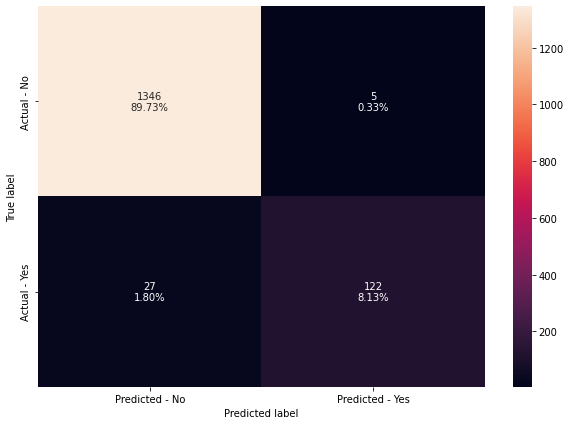

In [ ]:
make_confusion_matrix(estimator,y_test)

In [ ]:
# Accuracy on train and test
print("Accuracy on training set : ",estimator.score(X_train, y_train))
print("Accuracy on test set : ",estimator.score(X_test, y_test))
# Recall on train and test
get_recall_score(estimator)

Accuracy on training set :  0.9871428571428571
Accuracy on test set :  0.9786666666666667
Recall on training set :  0.8912386706948641
Recall on test set :  0.8187919463087249


Recall is worse for both train and test set after hyperparameter tuning.

### Decision Tree Visualization

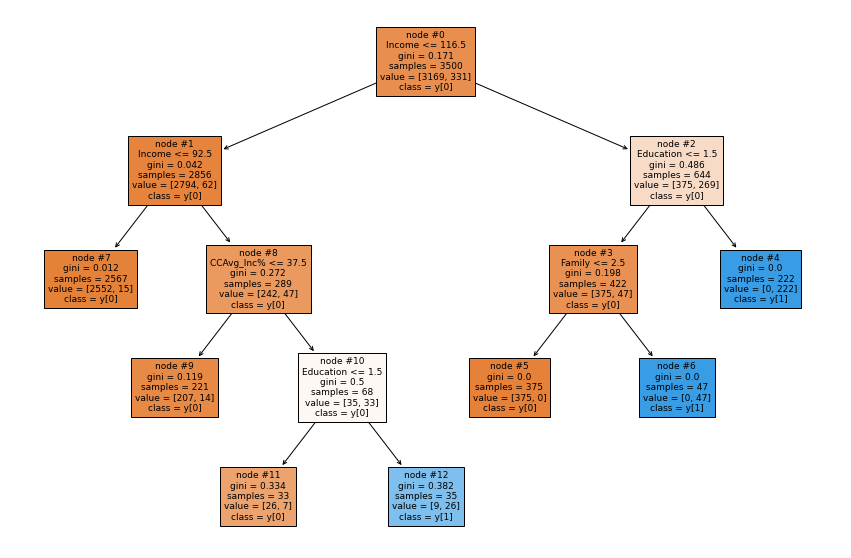

In [ ]:
plt.figure(figsize=(15,10))

tree.plot_tree(estimator,feature_names=feature_names,filled=True,fontsize=9,node_ids=True,class_names=True)
plt.show()

In [ ]:
# Text report showing the rules of a decision tree -

print(tree.export_text(estimator,feature_names=feature_names,show_weights=True))

|--- Income <= 116.50
|   |--- Income <= 92.50
|   |   |--- weights: [2552.00, 15.00] class: 0
|   |--- Income >  92.50
|   |   |--- CCAvg_Inc% <= 37.50
|   |   |   |--- weights: [207.00, 14.00] class: 0
|   |   |--- CCAvg_Inc% >  37.50
|   |   |   |--- Education <= 1.50
|   |   |   |   |--- weights: [26.00, 7.00] class: 0
|   |   |   |--- Education >  1.50
|   |   |   |   |--- weights: [9.00, 26.00] class: 1
|--- Income >  116.50
|   |--- Education <= 1.50
|   |   |--- Family <= 2.50
|   |   |   |--- weights: [375.00, 0.00] class: 0
|   |   |--- Family >  2.50
|   |   |   |--- weights: [0.00, 47.00] class: 1
|   |--- Education >  1.50
|   |   |--- weights: [0.00, 222.00] class: 1



In [ ]:
# importance of features in the tree building ( The importance of a feature is computed as the 
#(normalized) total reduction of the 'criterion' brought by that feature. It is also known as the Gini importance )

print (pd.DataFrame(estimator.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values(by = 'Imp', ascending = False))

#Here we will see that importance of features has increased

                Imp
Education     0.461
Income        0.342
Family        0.161
CCAvg_Inc%    0.036
ZIPCode_94234 0.000
...             ...
ZIPCode_92084 0.000
ZIPCode_92069 0.000
ZIPCode_92068 0.000
ZIPCode_92064 0.000
ZIPCode_96651 0.000

[478 rows x 1 columns]


Post pruning might give better results, since there is quite a good possibility that we might neglect some hyperparameters, post pruning will take care of all that. 

### Cost Complexity Pruning

Notes:
The DecisionTreeClassifier provides parameters such as min_samples_leaf and max_depth to prevent a tree from overfiting. Cost complexity pruning provides another option to control the size of a tree. In DecisionTreeClassifier, this pruning technique is parameterized by the cost complexity parameter, ccp_alpha. Greater values of ccp_alpha increase the number of nodes pruned. Here we only show the effect of ccp_alpha on regularizing the trees and how to choose a ccp_alpha based on validation scores.

**Total impurity of leaves vs effective alphas of pruned tree**

Notes:
Minimal cost complexity pruning recursively finds the node with the "weakest link". The weakest link is characterized by an effective alpha, where the nodes with the smallest effective alpha are pruned first. To get an idea of what values of ccp_alpha could be appropriate, scikit-learn provides DecisionTreeClassifier.cost_complexity_pruning_path that returns the effective alphas and the corresponding total leaf impurities at each step of the pruning process. As alpha increases, more of the tree is pruned, which increases the total impurity of its leaves.

In [ ]:
clf = DecisionTreeClassifier(random_state=1)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [ ]:
pd.DataFrame(path)

,ccp_alphas,impurities
0,0.000,0.000
1,0.000,0.001
2,0.000,0.002
3,0.000,0.004
4,0.000,0.005
5,0.000,0.005
6,0.000,0.005
7,0.000,0.006
8,0.000,0.007
9,0.000,0.008


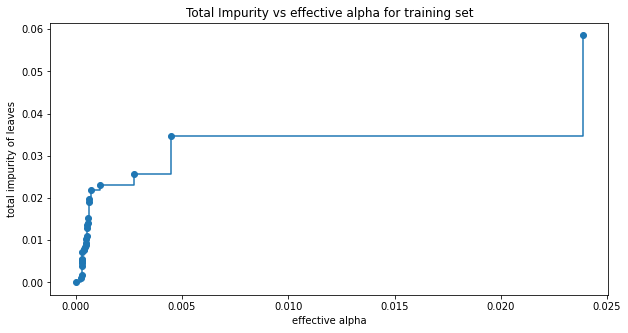

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

Next, we train a decision tree using the effective alphas. The last value in ccp_alphas is the alpha value that prunes the whole tree, leaving the tree, clfs[-1], with one node.

In [ ]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=1, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.056364969335601575


For the remainder, we remove the last element in clfs and ccp_alphas, because it is the trivial tree with only one node. Here we show that the number of nodes and tree depth decreases as alpha increases.

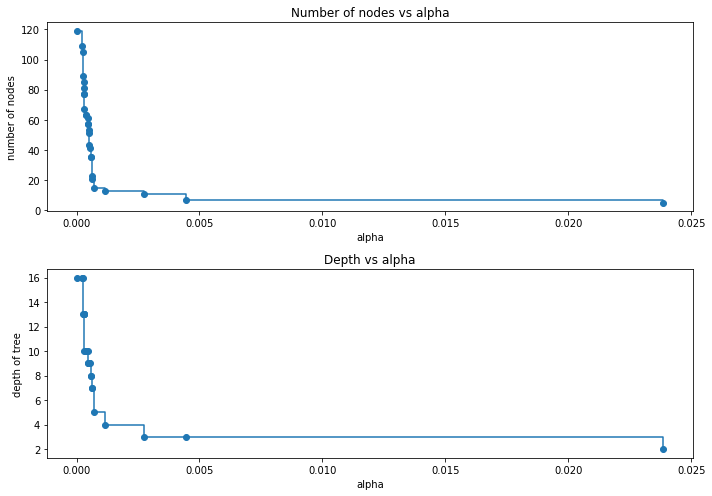

In [ ]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1,figsize=(10,7))
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

### Accuracy vs alpha for training and testing sets

When ccp_alpha is set to zero and keeping the other default parameters of DecisionTreeClassifier, the tree overfits, leading to a 100% training accuracy and 69% testing accuracy. As alpha increases, more of the tree is pruned, thus creating a decision tree that generalizes better.

In [ ]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

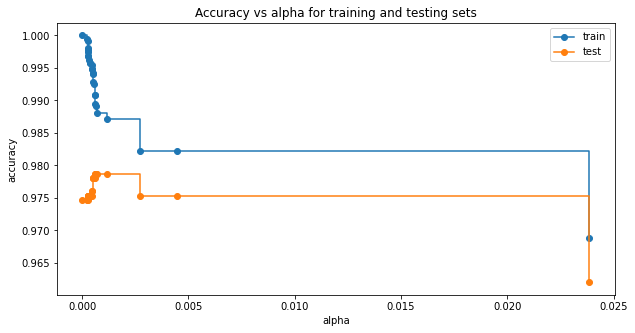

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [ ]:
index_best_model = np.argmax(test_scores)
best_model = clfs[index_best_model]
print(best_model)
print('Training accuracy of best model: ',best_model.score(X_train, y_train))
print('Test accuracy of best model: ',best_model.score(X_test, y_test))

DecisionTreeClassifier(ccp_alpha=0.0005952380952380953, random_state=1)
Training accuracy of best model:  0.9908571428571429
Test accuracy of best model:  0.9786666666666667


**Since accuracy isn't the right metric for our data we would want high recall**

In [ ]:
recall_train=[]
for clf in clfs:
    pred_train3=clf.predict(X_train)
    values_train=metrics.recall_score(y_train,pred_train3)
    recall_train.append(values_train)

In [ ]:
recall_test=[]
for clf in clfs:
    pred_test3=clf.predict(X_test)
    values_test=metrics.recall_score(y_test,pred_test3)
    recall_test.append(values_test)

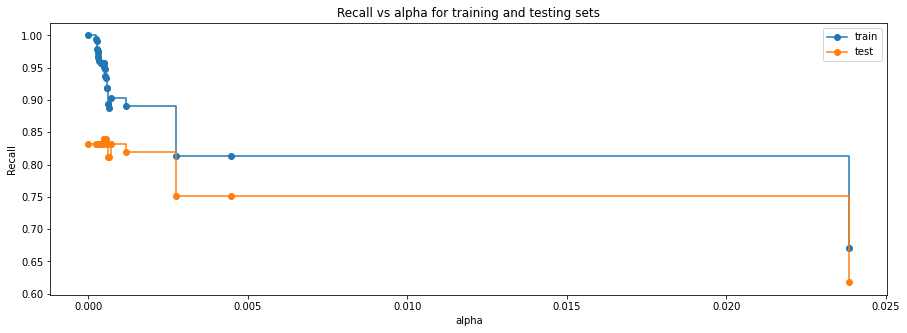

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_xlabel("alpha")
ax.set_ylabel("Recall")
ax.set_title("Recall vs alpha for training and testing sets")
ax.plot(ccp_alphas, recall_train, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, recall_test, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [ ]:
# creating the model where we get highest train and test recall
index_best_model = np.argmax(recall_test)
best_model = clfs[index_best_model]
print(best_model)

DecisionTreeClassifier(ccp_alpha=0.0004761904761904762, random_state=1)


### Confusion Matrix - post-pruned decision tree

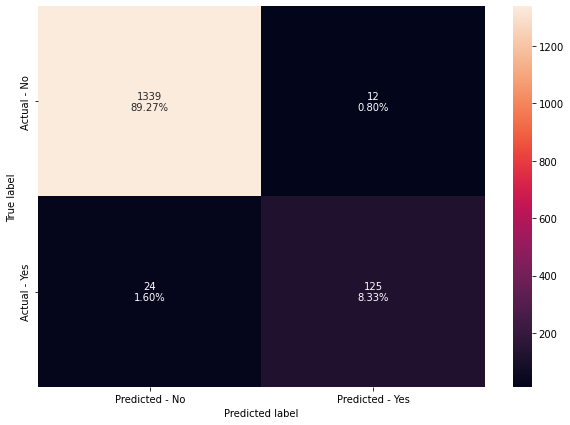

In [ ]:
make_confusion_matrix(best_model,y_test)

In [ ]:
# Recall on train and test
get_recall_score(best_model)

Recall on training set :  0.9577039274924471
Recall on test set :  0.8389261744966443


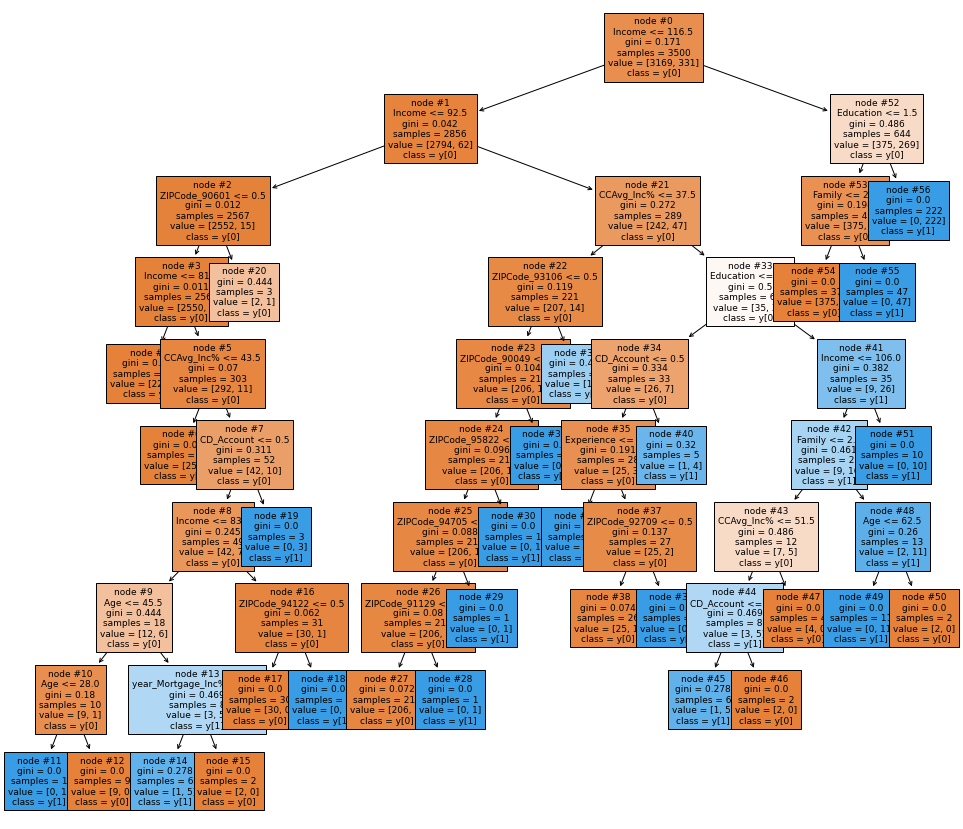

In [ ]:
plt.figure(figsize=(17,15))

tree.plot_tree(best_model,feature_names=feature_names,filled=True,fontsize=9,node_ids=True,class_names=True)
plt.show()

In [ ]:
# Text report showing the rules of a decision tree -

print(tree.export_text(best_model,feature_names=feature_names,show_weights=True))

|--- Income <= 116.50
|   |--- Income <= 92.50
|   |   |--- ZIPCode_90601 <= 0.50
|   |   |   |--- Income <= 81.50
|   |   |   |   |--- weights: [2258.00, 3.00] class: 0
|   |   |   |--- Income >  81.50
|   |   |   |   |--- CCAvg_Inc% <= 43.50
|   |   |   |   |   |--- weights: [250.00, 1.00] class: 0
|   |   |   |   |--- CCAvg_Inc% >  43.50
|   |   |   |   |   |--- CD_Account <= 0.50
|   |   |   |   |   |   |--- Income <= 83.50
|   |   |   |   |   |   |   |--- Age <= 45.50
|   |   |   |   |   |   |   |   |--- Age <= 28.00
|   |   |   |   |   |   |   |   |   |--- weights: [0.00, 1.00] class: 1
|   |   |   |   |   |   |   |   |--- Age >  28.00
|   |   |   |   |   |   |   |   |   |--- weights: [9.00, 0.00] class: 0
|   |   |   |   |   |   |   |--- Age >  45.50
|   |   |   |   |   |   |   |   |--- year_Mortgage_Inc% <= 5.00
|   |   |   |   |   |   |   |   |   |--- weights: [1.00, 5.00] class: 1
|   |   |   |   |   |   |   |   |--- year_Mortgage_Inc% >  5.00
|   |   |   |   |   |   |   |   

In [ ]:
# importance of features in the tree building ( The importance of a feature is computed as the 
#(normalized) total reduction of the 'criterion' brought by that feature. It is also known as the Gini importance )

print (pd.DataFrame(best_model.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values(by = 'Imp', ascending = False))

                Imp
Education     0.422
Income        0.322
Family        0.152
CCAvg_Inc%    0.042
CD_Account    0.018
...             ...
ZIPCode_92096 0.000
ZIPCode_92093 0.000
ZIPCode_92084 0.000
ZIPCode_92069 0.000
ZIPCode_96651 0.000

[478 rows x 1 columns]


In [ ]:
comparison_frame = pd.DataFrame({'Model':['Initial decision tree model','Decision tree with restricted maximum depth','Decision treee with hyperparameter tuning',
                                         'Decision tree with post-pruning'], 'Train_Recall':[1,0.81,0.89,0.95], 'Test_Recall':[0.83,0.75,0.81,0.84]}) 
comparison_frame

,Model,Train_Recall,Test_Recall
0,Initial decision tree model,1.000,0.830
1,Decision tree with restricted maximum depth,0.810,0.750
2,Decision treee with hyperparameter tuning,0.890,0.810
3,Decision tree with post-pruning,0.950,0.840


Decision Tree with post-pruning gives the highest recall on test set (0.84).

# Comparing Logistic Regression and Decision Tree

The metric we are using to evaluate the Logistic Regression Model is F1 while we are using Recall to evauate the Decision Tree.

Decision Tree is easier to interpret than Logistic Regression, it also bisects the space into smaller spaces, it automatically handles decision making thresholds. 

However, Decision tree is prone to overfitting and noise.

On the other hand, Logistic Regression is sturdy in the sense that is not prone to overifting and robust to noise. However is more complex, thresholds mut be set manually, and is more difficult to intrerpret.

if using Logistic Regression, consider using the Logistic Regression-0.37 Threshold that yields a Test F1 of 0.68.

If using Decision tree, consider using the Decision Tree with Post-Pruning that gives a Test Recall of 0.84.

Which model is better in our case or what model should we use? You can read this in our conclusions.


# Conclusions

This Logistic Regression model with a threshold of 0.37 can predict with an accuracy of 0.961 on the training set and  0.945 on the testing set, which liability customers will borrow money (Personal Loan) while maintaining other bank Products. Our model has f1 score of 0.672 on the testing and 0.772 on the training sets.  

The Decision Tree model w/ Post Pruning yields a recall of train 0.950	and of test 0.840 which are good.

In this particular case we would recommend trying the Decision tree model because not only is it easier to understand, but it can be visualized and its 'automatized' in the sense that since no threshold has to be chosen manually, this type of bias doesn't exist. We tried to minimize the overfitting and improve the model prunning it.

From the analysis, we determined that Income, CD Accounts, and Education are the most important features that influence whether a liability customer will purchase a Personal Loan Product. 

- Higher income customers, tend to purchase loans more than lower income customers. Customers in the Income range of 120K to 190K have the not only the most Personal Loans compared to other income ranges but also the highest density of Personal Loans within their group. 

- Customers with CD Accounts also tend to purchase more Personal Loans.

- Customers with higher education (Professional/Advanced) tend to purchase more Personal Loans.

Regarding our features that are less important than the 3 above, we have a few observations:

- The Age group in the 60s, 20s, and 30s, tend to purchase more loans than the other age groups.
- Family size 4 customers tend to purchase more loans.
- CC Average, customers that spend an average of 40-50% of their monthly income on a credit card, also tend to purchase more loans.
- Mortgage customers with monthly values of 5-15% of their monthly income also tend to purchase more loans.
- Security Accounts customers also tend to purchase more loans than those that do not have one.
- ZIP Code is a controversial observation. We noticed that ZIP codes in which a large university is located tend to purchase more loans. These customers are not necessarily students, but they may be associated to the schools in those ZIP code areas. In particular ZIP Codes 94720, 94305, 95616, 90095, and 93106 stand out.

Other features that don't seem to be relevant are Experience, Credit Card, and Online access.

Regarding our model, we use Logistic Regression-0.58 Threshold which yields the highest F1 score and if we use Decision Tree with post pruning, a recall of 0.95 (Train) and 0.84 (Test).

# Recommendations

We dare to make the following recommendations:

Target the following Liability Customers:
1. Located in ZIP Codes where large or prestigious universities or colleges, including Silicon Valley.
2. Income over 100K. 
3. With Higher Education (Advanced Degrees/Professional Degrees) first, then with Postgraduate education.

Fine Tune the Customers in the Target Group above (Preferably):
4. Have a CD_Account.
5. Have a Mortgage monthly payment is no more than 15% of their monthly income.
6. Do not have more than 50% of their monthly income on their monthly average credit card expense.
7. Have 4 or 3 family members.

If looking for new customers, we recommend attracting new customers in the ZIP Codes mentioned above and not in the undegraduate age group but in the age ranges of 30s to 60s.

Thank you.